### Udacity Data Science Nanodegree
### Project 1: Writing a Data Scientist Blog Post
---

# Part II - London Airbnb Data - EDA
## by Juanita Smith


<a id='intro'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Introduction</span>

### Context:
Since 2008, guests and hosts have used Airbnb to travel in a more unique, personalized way. As part of the Airbnb Inside initiative, this dataset describes the listing activity of homestays in London, United Kingdom.


### Dictionary:

In Part I, Airbnb London listing data was cleaned, and only a subset of the available features was selected to support analysis of below questions.

**Recap of the origin of data:**

Airbnb activity is included for **London** and is a snapshot of booking availability on 8 June 2023

Data was downloaded from Airbnb [here](http://insideairbnb.com/get-the-data/). Scroll down to London section. 

To support this analysis, only listings and calendar data was needed.

Metadata are available [here](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=1322284596)

## Are you like me going the Taylor Swift concert in London next June and looking for the best place to stay ?

This project will focus on answering questions below, whilst this notebook focus on **question 4 in blue**

1) Are some hosts running a business, and if so, what is the impact on price ?
> - Can we identify businesses by the duration of rentals ? Are businesses focusing on short or long term term rentals? What impact have rental duration have on price ?
> - Are some hosts running a business with multiple listings ? If so, how does this affect the price ?


2) Host Analysis: How does **host excellence** influence price ?
> - Super hosts seems to describe their properties better, how does this effect price and availability ?


3) What effect does **star ratings** have on property price ?
> - Would a 5-star vs 3-star listing in the same location cost more ?


<span style="color:blue; font-size:20px; line-height:20px; font-family: Calibri;">4) Predict average daily listing price</span>

> - Knowing the impact of host excellence and star ratings above, could we make an accurate average daily price prediction ?

- Assumption: Normality of the predictors or the label
- Assumption 1: Linear Relationship between the Target and the Feature
- Assumption 2: Normality of the Error Terms, meaning residuals should be normally distributed with mean as centre

In [1]:
# import all packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import glob
import os
import missingno as msno
from datetime import datetime

from patsy import dmatrices
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, PredictionErrorDisplay, median_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer

from sklearn.compose import TransformedTargetRegressor


from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
import scipy as sp

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold  
from sklearn.compose import TransformedTargetRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.compose import make_column_selector
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import RepeatedKFold, cross_validate


# import warnings
# warnings.filterwarnings("ignore")

# Import custom modules
from project1_blog.src.utils import reduce_mem_usage, create_folder, entity_recognision, fit_imputer
import project1_blog.src.visuals as vs

# set plots to be embedded inline
%matplotlib inline

# suppress matplotlib user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# # use high resolution if this project is run on an apple device
# %config InlineBackend.figure_format='retina'

# Make your Jupyter Notebook wider
from IPython.display import display, HTML
display(HTML('<style>.container { width:80% !important; }</style>'))

# environment settings
# display all columns and rows during visual inspection
pd.options.display.max_columns = None
pd.options.display.max_rows = 900

# stop scientific notation on graphs
# pd.options.display.float_format = '{:.0f}'.format

In [2]:
# set default plot formatting and colors
BASE_COLOR, BASE_HIGHLIGHT_INTENSE, BASE_HIGHLIGHT, BASE_COMPLEMENTRY, BASE_GREY, BASE_COLOR_SUB1, BASE_COLOR_SUB2, SYMBOLS = vs.set_plot_defaults()

In [3]:
# default file paths
# FILE_NAME_RAW = '../data/clean/listing_clean.pkl'
# FILE_NAME_CLEAN = '../data/clean/listing_clean.pkl'
FILE_NAME_ENHANCED = '../data/clean/listing_enhanced.pkl'

In [4]:
random_state = 88

<a id='getdata'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Gather Data</span>

In [5]:
# features to be used in modelling
cols = ['host_is_superhost', 'accommodates', 'bedrooms', 'bathrooms',
       'minimum_minimum_nights', 'calculated_host_listings_count', 'host_years_active', 'price_mean',
       'private_bathroom', 'host_same_location', 'is_business', 'availability_90', 'neighbourhood_cleansed', 'property_type', 'review_scores_location']

In [6]:
# load the enhanced listing file 
listing = pd.read_pickle(FILE_NAME_ENHANCED)
listing.head(3)

listing_id                          listing_url  \
0      157714  https://www.airbnb.com/rooms/157714   
1       13913   https://www.airbnb.com/rooms/13913   
2       15400   https://www.airbnb.com/rooms/15400   

                                                name  host_id host_name  \
0  Townhouse in Hammersmith · ★4.71 · 1 bedroom ·...   757377    Eilinn   
1  Rental unit in Islington · ★4.80 · 1 bedroom ·...    54730     Alina   
2  Rental unit in London · ★4.80 · 1 bedroom · 1 ...    60302  Philippa   

   host_response_time  host_response_rate  host_acceptance_rate  \
0  within a few hours                  90                    68   
1      within an hour                 100                    78   
2        within a day                 100                    47   

   host_is_superhost host_neighbourhood  host_has_profile_pic  \
0              False        Hammersmith                  True   
1              False    LB of Islington                  True   
2              False            Chelsea                  True   

   host_identity_verified  neighbourhood_cleansed  latitude  longitude  \
0                    True  Hammersmith and Fulham  51.48974   -0.22208   
1                    True               Islington  51.56861   -0.11270   
2                    True  Kensington and Chelsea  51.48780   -0.16813   

                 property_type        room_type  accommodates  bathrooms  \
0    Private room in townhouse     Private room             3        1.5   
1  Private room in rental unit     Private room             1        1.0   
2           Entire rental unit  Entire home/apt             2        1.0   

   bedrooms  beds  price  minimum_minimum_nights  minimum_maximum_nights  \
0       1.0   1.0     69                       4                      21   
1       1.0   1.0     79                       1                      29   
2       1.0   1.0    100                       7                      30   

   availability_30  availability_60  availability_90  availability_365  \
0               10               37               67                67   
1               23               48               78               353   
2                0                2                2                70   

   number_of_reviews  number_of_reviews_ltm  number_of_reviews_l30d  \
0                175                     10                       0   
1                 41                     15                       0   
2                 94                      5                       0   

  first_review last_review  review_scores_rating  review_scores_accuracy  \
0   2011-07-13  2023-05-02                  4.71                    4.66   
1   2010-08-18  2022-12-11                  4.80                    4.72   
2   2009-12-21  2023-05-01                  4.80                    4.85   

   review_scores_cleanliness  review_scores_checkin  \
0                       4.78                   4.84   
1                       4.72                   4.74   
2                       4.88                   4.88   

   review_scores_communication  review_scores_location  review_scores_value  \
0                         4.83                    4.76                 4.66   
1                         4.82                    4.69                 4.69   
2                         4.83                    4.93                 4.74   

   instant_bookable  calculated_host_listings_count  \
0             False                               1   
1             False                               2   
2             False                               1   

   calculated_host_listings_count_entire_homes  \
0                                            0   
1                                            1   
2                                            1   

   calculated_host_listings_count_private_rooms  \
0                                             1   
1                                             1   
2                                             0 

In [7]:
# restrict the values to be predicted to a min / max range
# minimum_before = list(listing.iloc[:, :].min(axis=0))
# maximum_before = list(listing.iloc[:, :].max(axis=0))

# # make sure features that will be one hot encoded have no spaces in it's values, as it will become part of heading
# categorical_columns = ["room_type"]
# listing[categorical_columns] = listing[categorical_columns].apply(lambda x: x.str.replace(' ', '_').str.lower())
# listing[categorical_columns] = listing[categorical_columns].apply(lambda x: x.str.replace('/', '_').str.lower())


# listing = pd.get_dummies(data=listing, 
#                     columns=categorical_columns, 
#                     dummy_na=False, 
#                     prefix_sep='_', 
#                     drop_first=True)

# listing.head()

In [8]:
# # impute missing values
# imputer = IterativeImputer(random_state=random_state,
#                            imputation_order='descending',
#                            n_nearest_features=None,
#                            initial_strategy='most_frequent',
#                            max_iter=30,
# #                            min_value=minimum_before,
# #                            max_value=maximum_before,
#                            skip_complete=True,
#                            # tol=0.0001, 
#                            verbose=0)

# imputer.fit(listing)

# listing[cols] = imputer.transform(listing[cols])

<a id='featureeng'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Feature engineering</span>

In [9]:
listing_clean = listing.copy()

In [10]:
# make sure that each record is a unique listing  
listing_clean['listing_id'].duplicated().sum()

0

In [11]:
# for easy trouble shooting, lets make listing_id the index
listing_clean = listing_clean.set_index('listing_id')
listing_clean = listing_clean.loc[:, cols]
listing_clean.head()

host_is_superhost  accommodates  bedrooms  bathrooms  \
listing_id                                                         
157714                  False             3       1.0        1.5   
13913                   False             1       1.0        1.0   
15400                   False             2       1.0        1.0   
306333                  False             5       2.0        1.0   
159736                  False             2       1.0        1.0   

            minimum_minimum_nights  calculated_host_listings_count  \
listing_id                                                           
157714                           4                               1   
13913                            1                               2   
15400                            7                               1   
306333                           2                               1   
159736                           4                               4   

            host_years_active  price_mean  private_bathroom  \
listing_id                                                    
157714                     12          70              True   
13913                      14          79             False   
15400                      14         107              True   
306333                     11         198              True   
159736                     12          62             False   

            host_same_location  is_business  availability_90  \
listing_id                                                     
157714                    True        False               67   
13913                     True        False               78   
15400                     True        False                2   
306333                   False        False                4   
159736                   False        False                2   

            neighbourhood_cleansed                property_type  \
listing_id                                                        
157714      Hammersmith and Fulham    Private room in townhouse   
13913                    Islington  Private room in rental unit   
15400       Kensington and Chelsea           Entire rental unit   
306333                     Hackney           Entire rental unit   
159736                     Lambeth  Private room in rental unit   

            review_scores_location  
listing_id                          
157714                        4.76  
13913                         4.69  
15400                         4.93  
306333                        4.89  
159736                        4.34

In [12]:
# if host is active for 0 years, make it 1
# listing_clean['host_years_active'] = np.where(listing_clean['host_years_active'] == 0, 1, listing_clean['host_years_active'])

In [13]:
# make sure features that will be one hot encoded have no spaces in it's values, as it will become part of heading
categorical_columns = ['neighbourhood_cleansed', 'property_type']
listing_clean[categorical_columns] = listing_clean[categorical_columns].apply(lambda x: x.str.replace(' ', '_').str.lower())
listing_clean[categorical_columns] = listing_clean[categorical_columns].apply(lambda x: x.str.replace('/', '_').str.lower())

In [14]:
# check for outliers
listing_clean.describe([0.25, 0.5, 0.75, 0.9, 0.99, 0.999])

accommodates      bedrooms     bathrooms  minimum_minimum_nights  \
count  68923.000000  68867.000000  68842.000000            68923.000000   
mean       3.168014      1.475975      1.338630                4.350202   
std        1.985088      0.962448      0.676587                9.065348   
min        1.000000      0.000000      0.000000                1.000000   
25%        2.000000      1.000000      1.000000                1.000000   
50%        2.000000      1.000000      1.000000                2.000000   
75%        4.000000      2.000000      1.500000                4.000000   
90%        6.000000      3.000000      2.000000                7.000000   
99%       10.000000      5.000000      3.500000               45.000000   
99.9%     16.000000      7.000000      5.500000               90.000000   
max       16.000000     50.000000     50.000000               90.000000   

       calculated_host_listings_count  host_years_active    price_mean  \
count                    68923.000000       68923.000000  68923.000000   
mean                        19.274059           6.251208    202.492608   
std                         62.684541           3.230126    240.753573   
min                          1.000000           0.000000      7.000000   
25%                          1.000000           4.000000     70.000000   
50%                          2.000000           7.000000    129.000000   
75%                          7.000000           9.000000    232.000000   
90%                         40.000000          10.000000    409.000000   
99%                        291.000000          12.000000   1507.780000   
99.9%                      543.000000          14.000000   1791.078000   
max                        543.000000          15.000000   2000.000000   

       availability_90  review_scores_location  
count     68923.000000            47720.000000  
mean         33.066770                4.709157  
std          31.683168                0.441736  
min           0.000000                0.000000  
25%           0.000000                4.620000  
50%          26.000000                4.830000  
75%          61.000000                5.000000  
90%          83.000000                5.000000  
99%          90.000000                5.000000  
99.9%        90.000000                5.000000  
max          90.000000                5.000000

In [15]:
# further remove accessive prices if it's not a business
rows_to_remove = listing_clean[(listing_clean.is_business == False) & (listing_clean.price_mean > 1500)].index
listing_clean = listing_clean.drop(index=rows_to_remove)

In [16]:
# remove records with listings hosting too many people
listing_clean = listing_clean[listing_clean['accommodates'] <= 10]
listing_clean = listing_clean[listing_clean['bedrooms'] <= 7]
listing_clean = listing_clean[listing_clean['bathrooms'] <= 6]
listing_clean = listing_clean[listing_clean['price_mean'] <= 1500]
listing_clean.describe([0.25, 0.5, 0.75, 0.9, 0.99, 0.999])

accommodates      bedrooms     bathrooms  minimum_minimum_nights  \
count  67647.000000  67647.000000  67647.000000            67647.000000   
mean       3.109421      1.449495      1.319223                4.362396   
std        1.816949      0.874694      0.569534                9.109552   
min        1.000000      0.000000      0.000000                1.000000   
25%        2.000000      1.000000      1.000000                1.000000   
50%        2.000000      1.000000      1.000000                2.000000   
75%        4.000000      2.000000      1.500000                4.000000   
90%        6.000000      3.000000      2.000000                7.000000   
99%        9.000000      4.000000      3.500000               45.000000   
99.9%     10.000000      6.000000      4.500000               90.000000   
max       10.000000      7.000000      6.000000               90.000000   

       calculated_host_listings_count  host_years_active    price_mean  \
count                    67647.000000       67647.000000  67647.000000   
mean                        16.357355           6.252029    185.929738   
std                         51.391357           3.240779    190.628383   
min                          1.000000           0.000000      7.000000   
25%                          1.000000           4.000000     70.000000   
50%                          2.000000           7.000000    126.000000   
75%                          7.000000           9.000000    225.000000   
90%                         36.000000          10.000000    387.000000   
99%                        289.000000          12.000000   1000.000000   
99.9%                      543.000000          14.000000   1435.062000   
max                        543.000000          15.000000   1500.000000   

       availability_90  review_scores_location  
count     67647.000000            47090.000000  
mean         32.877659                4.709893  
std          31.544290                0.440755  
min           0.000000                0.000000  
25%           0.000000                4.620000  
50%          25.000000                4.830000  
75%          60.000000                5.000000  
90%          83.000000                5.000000  
99%          90.000000                5.000000  
99.9%        90.000000                5.000000  
max          90.000000                5.000000

In [17]:
# correct datatypes
listing['neighbourhood_cleansed'] = listing['neighbourhood_cleansed'].astype('category')
listing_clean['property_type'] = listing_clean['property_type'].astype('category')
# listing_clean['room_type'] = listing_clean['room_type'].astype('category')
listing_clean['bedrooms'] = listing_clean['bedrooms'].astype(int)

In [18]:
listing_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67647 entries, 157714 to 908453389034894825
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   host_is_superhost               67647 non-null  bool    
 1   accommodates                    67647 non-null  int64   
 2   bedrooms                        67647 non-null  int64   
 3   bathrooms                       67647 non-null  float64 
 4   minimum_minimum_nights          67647 non-null  int64   
 5   calculated_host_listings_count  67647 non-null  int64   
 6   host_years_active               67647 non-null  int64   
 7   price_mean                      67647 non-null  int64   
 8   private_bathroom                67647 non-null  bool    
 9   host_same_location              67647 non-null  bool    
 10  is_business                     67647 non-null  bool    
 11  availability_90                 67647 non-null  int64   
 12  neigh

### TODO:
There is nothing to indicate why these properties have higher prices, there is no differenciation. Consider adding review and host reponse data

<a id='univariate'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Univariate Analysis</span>

#### Let's double check target feature distribution. Is it normally distributed?

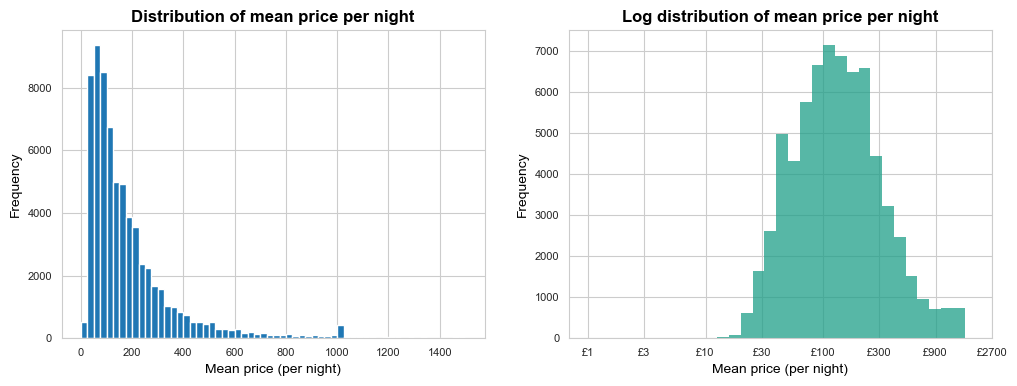

In [19]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
xbinsize = 25
xbins = np.arange(0, listing_clean['price_mean'].max()+xbinsize, xbinsize)
plt.hist(data=listing, x='price_mean', bins=xbins)
plt.title('Distribution of mean price per night')
plt.xlabel('Mean price (per night)')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
log_binsize = 0.1
xbins = 10 ** np.arange(0, np.log10(listing_clean['price_mean'].max())+log_binsize, log_binsize)
sns.histplot(data=listing, x='price_mean', bins=xbins, color=BASE_COLOR_SUB2, kde=False)
plt.xscale('log')
ticks = [1, 3, 10, 30, 100, 300, 900, 2700]
labels = ['£{}'.format(tick) for tick in ticks]
plt.xticks(ticks,labels)

plt.title('Log distribution of mean price per night')
plt.xlabel('Mean price (per night)')
plt.ylabel('Frequency')

plt.show()

#### Let's double check the distribution of independent variables

In [20]:
# we want different approaches for numeric vs categorical features
numerical_features = listing_clean.select_dtypes(include='number').columns.tolist() 
numerical_features.remove('price_mean')
categorical_features = listing_clean.select_dtypes(exclude='number').columns.tolist() 

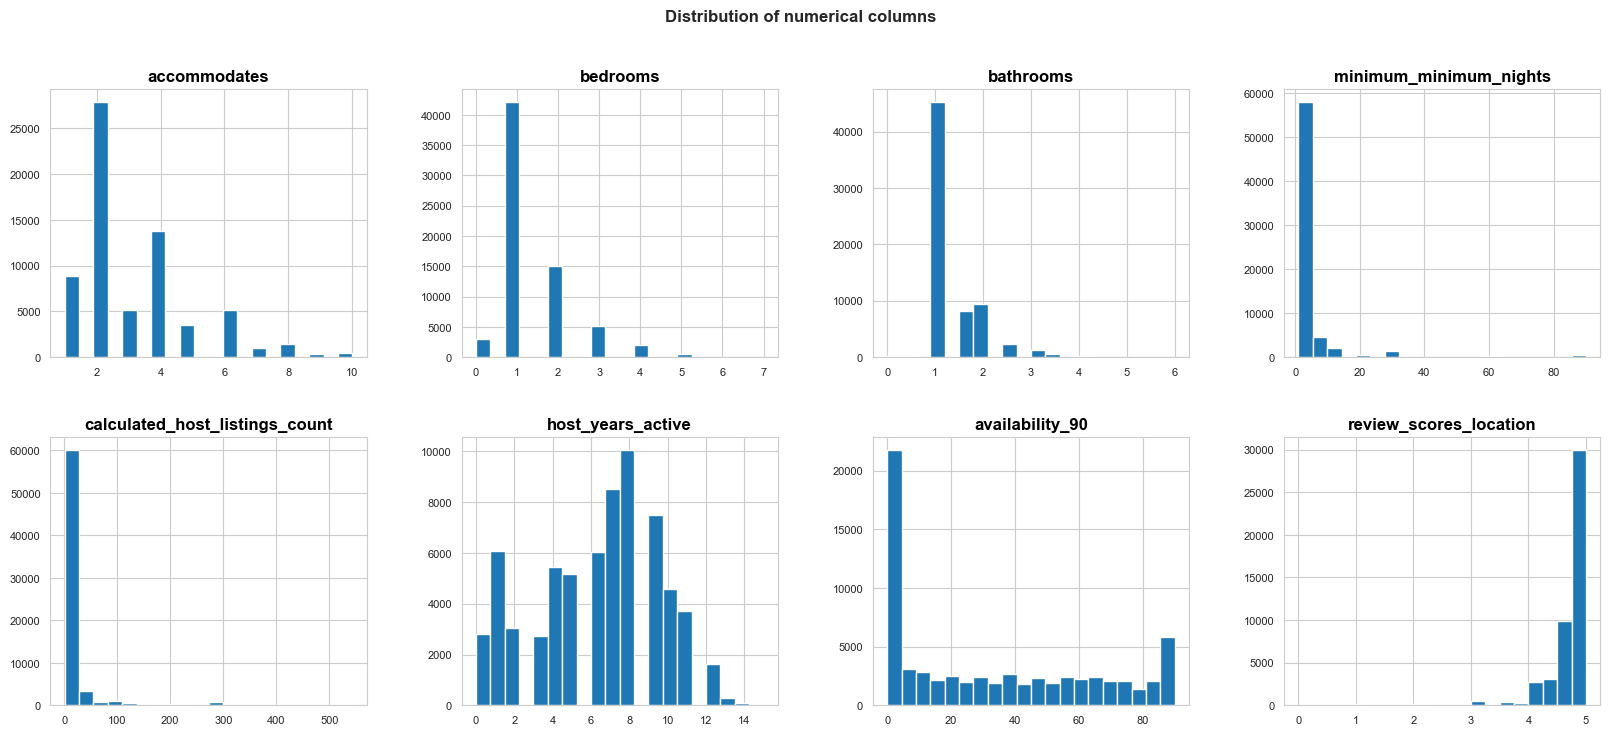

In [21]:
# distribution of numerical columns
pd.plotting.hist_frame(listing_clean, figsize=(20,8), bins=20, layout=(2,4), column=numerical_features, xlabelsize=8, ylabelsize=8)
plt.suptitle('Distribution of numerical columns')
plt.show()

In [22]:
def hist_by_cat(df, col, title='Distribution for', topn=20, base_color=BASE_COLOR,
                   base_highlight=BASE_HIGHLIGHT_INTENSE,
                   lookup=False, df_lookup=None, df_lookup_field=None, figsize=(8,4)):
    """ Count plot - first 3 highest bars are highlighted """

    # calculate top category and order of bar charts
    top = df[col].value_counts(ascending=False)
    top_order = top.index[:topn]
    
    # update topn to max value
    topn = len(top_order) - 1

    # replace index key with key and description
    if lookup:
        top.index = top.index + ':' + df_lookup.loc[top.index][df_lookup_field]

    if topn > 3:    
        clrs = [base_color if i >= 3 else base_highlight for i in np.arange(0, topn + 1, 1)]
    else:
        clrs = [base_color if i >= 3 else base_color for i in np.arange(0, topn + 1, 1)]

    plt.figure(figsize=figsize)
    ax = sns.countplot(data=df, y=col, hue=col, hue_order=top_order, order=top_order, palette=clrs, orient='h', width=0.5, legend=False)

    
    plt.title('{} {}'.format(title, col), weight='bold')
    plt.xlabel('Frequency')
    plt.ylabel(col)
#     ax.legend().set_visible(False)

    # improve xticks and labels      
    ticks, xlabels, binsize = vs.improve_yticks(top.iloc[0])
    plt.xticks(ticks, xlabels, fontsize=8)

#   calculate and print % on the top of each bar
    ticks = ax.get_yticks()
    new_labels = []
    locs, labels = plt.yticks()
    for loc, label in zip(locs, labels):
        count = top.iloc[loc]
        perc = '{:0.1f}%'.format((count / top.sum()) * 100)
        text = top.index[loc]
        new_labels.append(text)
        plt.text(count + (0.2 * binsize), loc, perc, ha='center', va='center', color='black', fontsize=6,
                 weight='ultralight')
    plt.yticks(ticks, new_labels, fontsize=8, weight='ultralight')

    plt.tight_layout()
    plt.show()

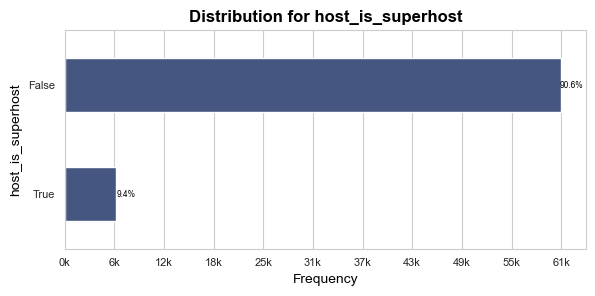

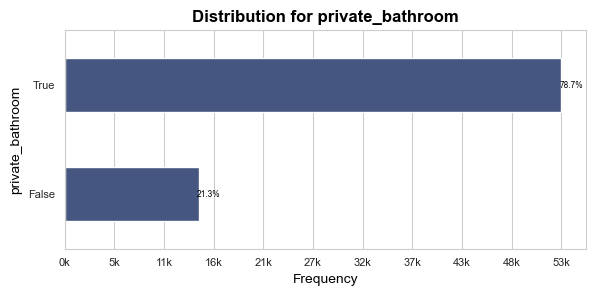

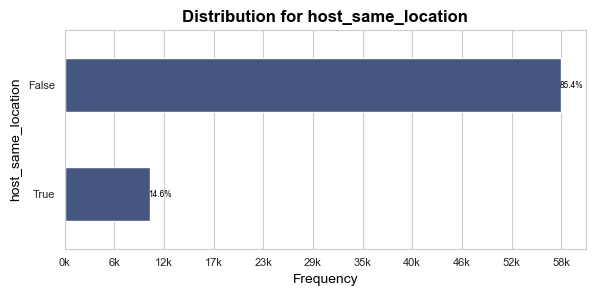

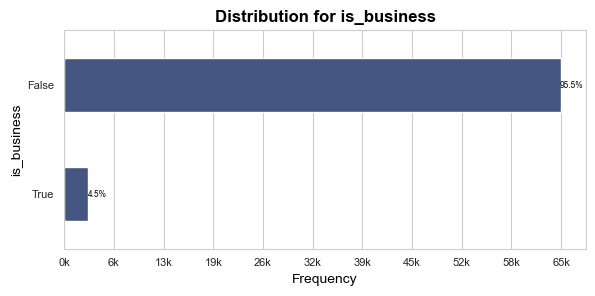

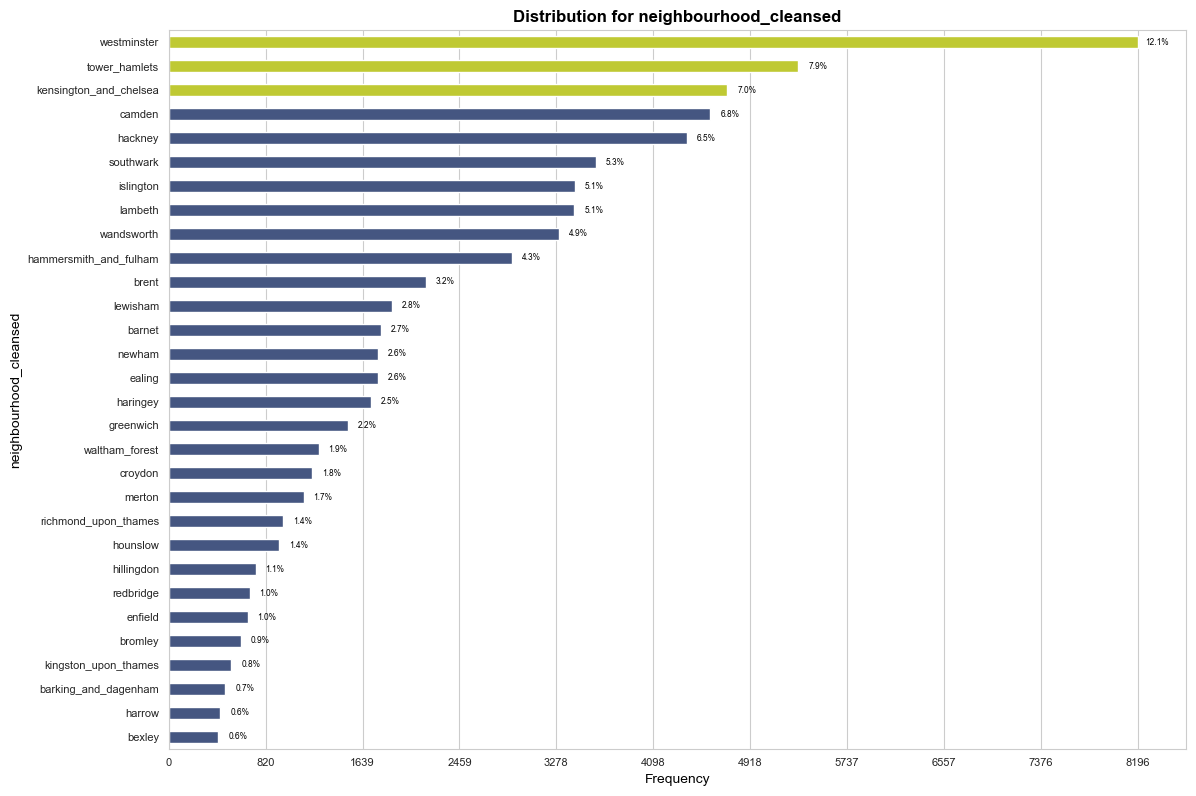

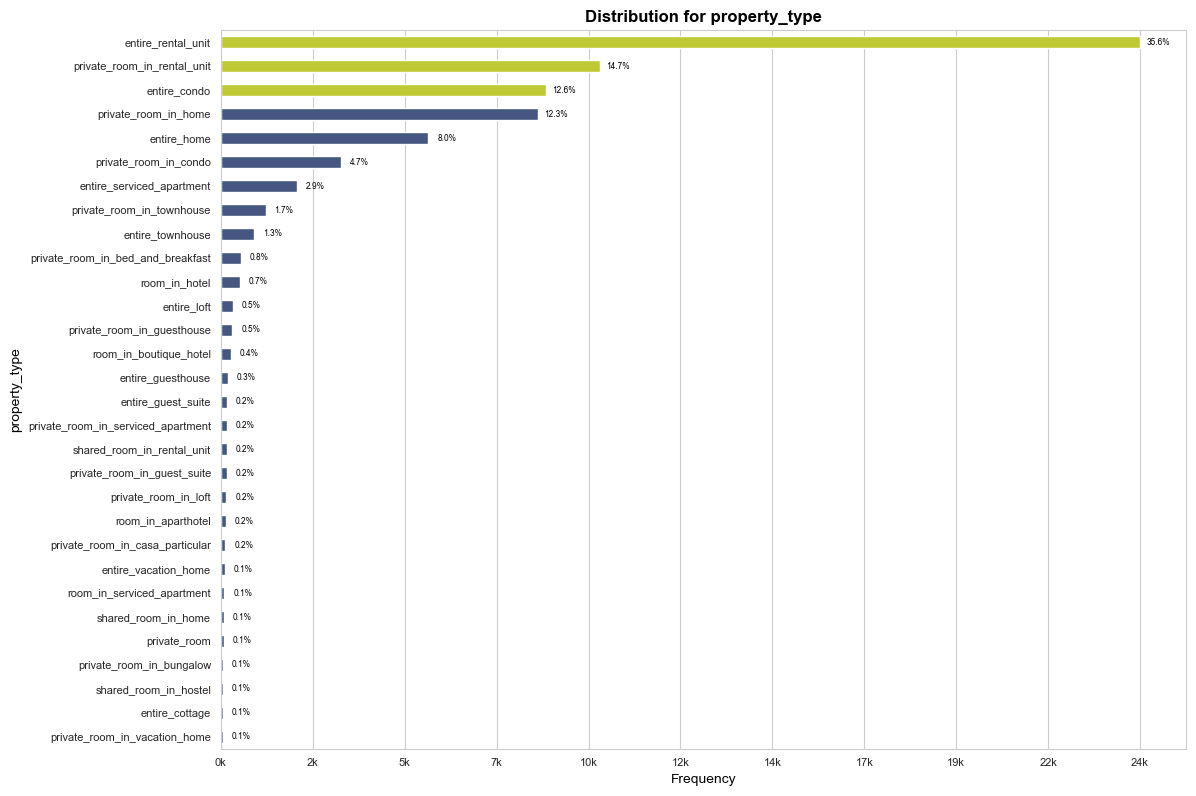

In [23]:
# plot distributions for categorical features
for col in categorical_features:
    if listing_clean[col].nunique() < 5:
        figsize=(6,3)
    else: 
        figsize=(12,8)
    hist_by_cat(df=listing_clean, col=col, topn=30, figsize=figsize)

<a id='Bivariate'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Bivariate Analysis</span>

#### Correlation analysis
- Select features correlated with price
- Make sure independent variables does not have too high correlations

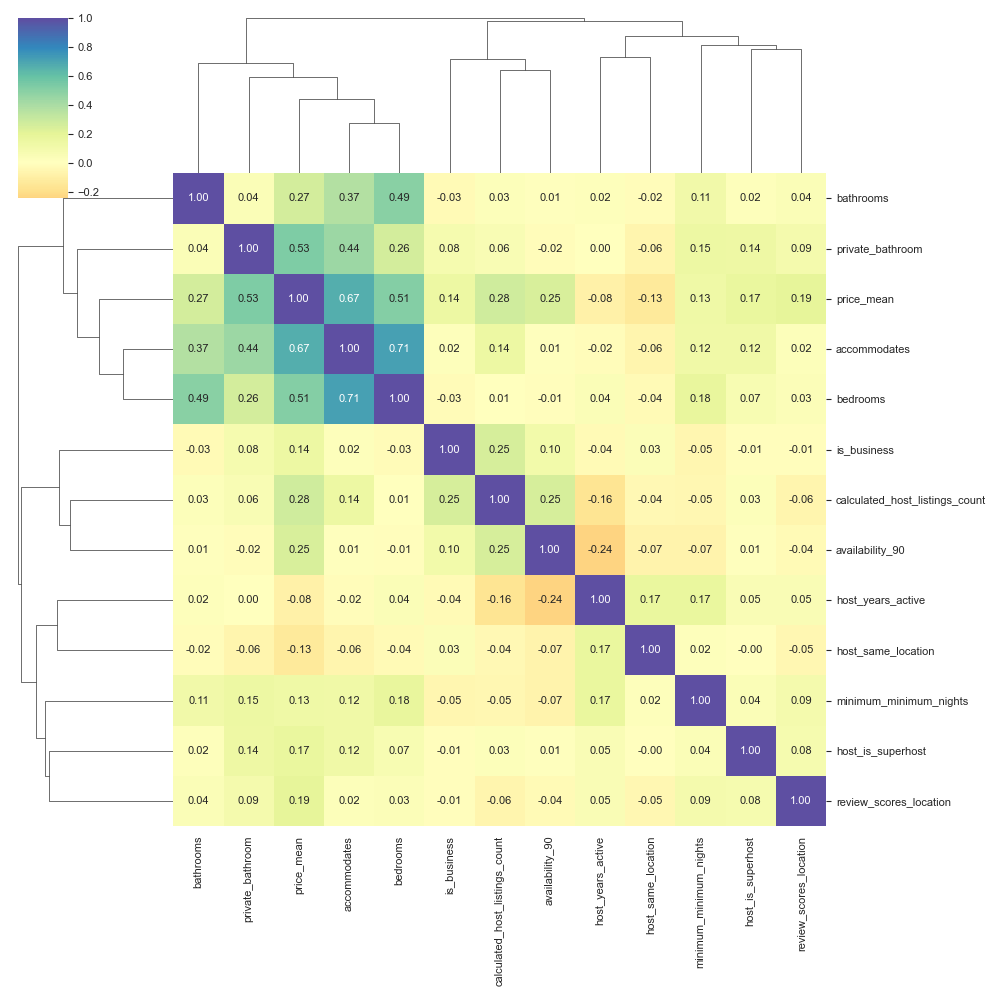

In [24]:
# sns.set(font_scale=1)
sns.clustermap(listing_clean.corr(method='spearman', numeric_only=True, min_periods=1), cmap="Spectral", center=0, annot=True, fmt='.2f', 
               annot_kws={"fontsize":8}, figsize=(10,10))

plt.xticks(fontsize=10)
plt.show()

#### Which kind of relationship features have with price ?

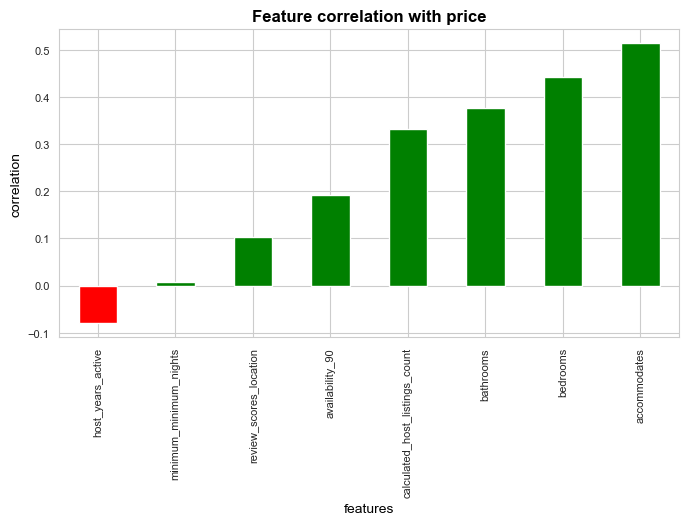

In [25]:
#  Get correlation of features with mean price
corr_matrix = listing_clean[numerical_features].corrwith(listing_clean["price_mean"]).sort_values()

# Plot feature correlations to no_show
corr_matrix.plot(kind='bar', color=np.vectorize({True: 'g', False: 'r'}.get)(corr_matrix > 0))
plt.xticks(rotation='vertical')
plt.ylabel('correlation')
plt.xlabel('features')
plt.title('Feature correlation with price')
plt.show()

In [26]:
numerical_features

['accommodates',
 'bedrooms',
 'bathrooms',
 'minimum_minimum_nights',
 'calculated_host_listings_count',
 'host_years_active',
 'availability_90',
 'review_scores_location']

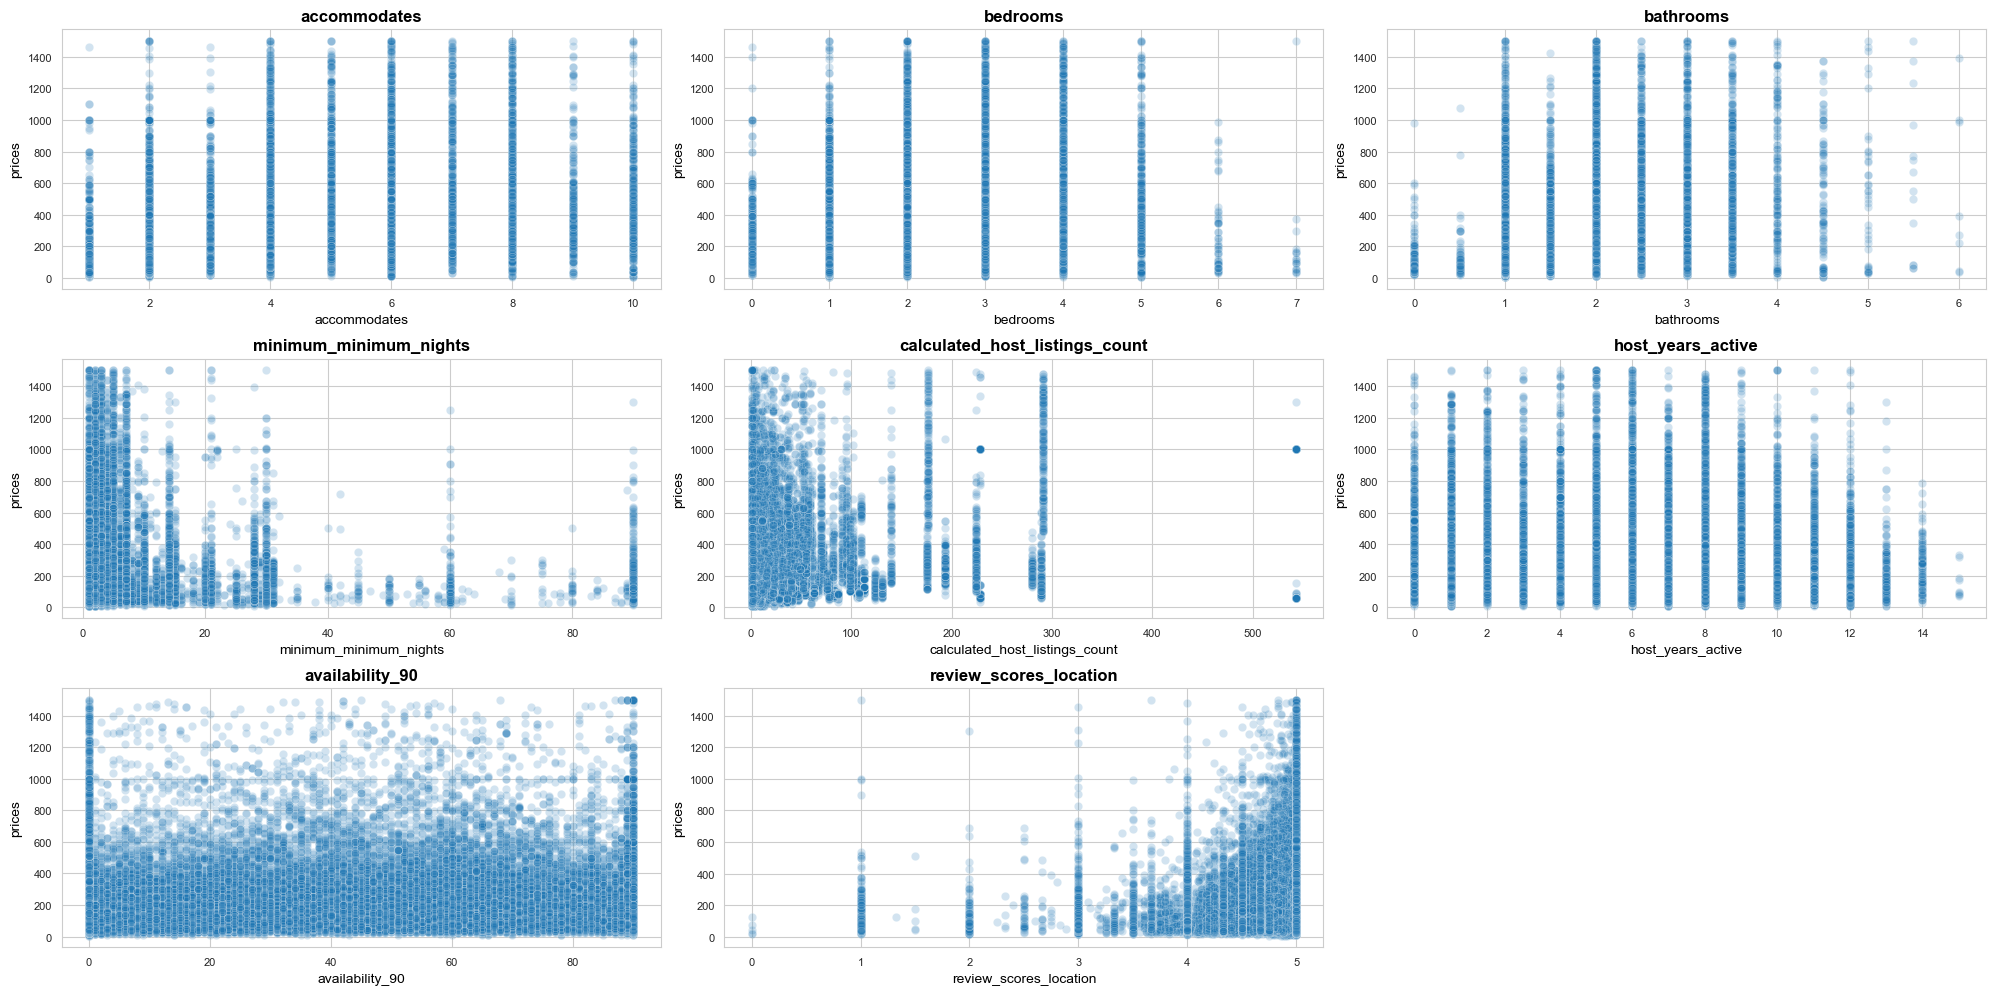

In [27]:
plt.figure(figsize=(20, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(3, 3, i+1)
    sns.scatterplot(x=listing_clean[col], y=listing_clean['price_mean'], alpha=0.2)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('prices')
plt.tight_layout()

In [28]:
# Correlation analysis

# # take a sample of listings to speed of performance for regplot relationship
# sample = np.random.choice(listing_reduced.shape[0], 20000, replace=False)
# listing_sample = listing_clean.iloc[sample].copy()

# # listing_sample = listing_sample[cols_of_interest].copy()
# listing_sample.dropna(inplace=True)

listing_clean['price_group'] = np.where(listing_clean['price_mean'] <= 500, 0, 1)

# sns.set(style='ticks')

# x_vars = numerical_features


# for col in x_vars:
#     sns.lmplot(data=listing_clean, x=col, y='price_mean', hue='price_group', x_jitter=0.1, palette='viridis_r', 
#                scatter_kws={'s':15, 'edgecolor':'black', 'linewidths':0.2})

# plt.show()

# # reset default plot formatting back as PairGrid change the defaults somehow
# BASE_COLOR, BASE_HIGHLIGHT_INTENSE, BASE_HIGHLIGHT, BASE_COMPLEMENTRY, BASE_GREY, BASE_COLOR_ARR, BASE_COLOR_DEP, SYMBOLS = vs.set_plot_defaults()

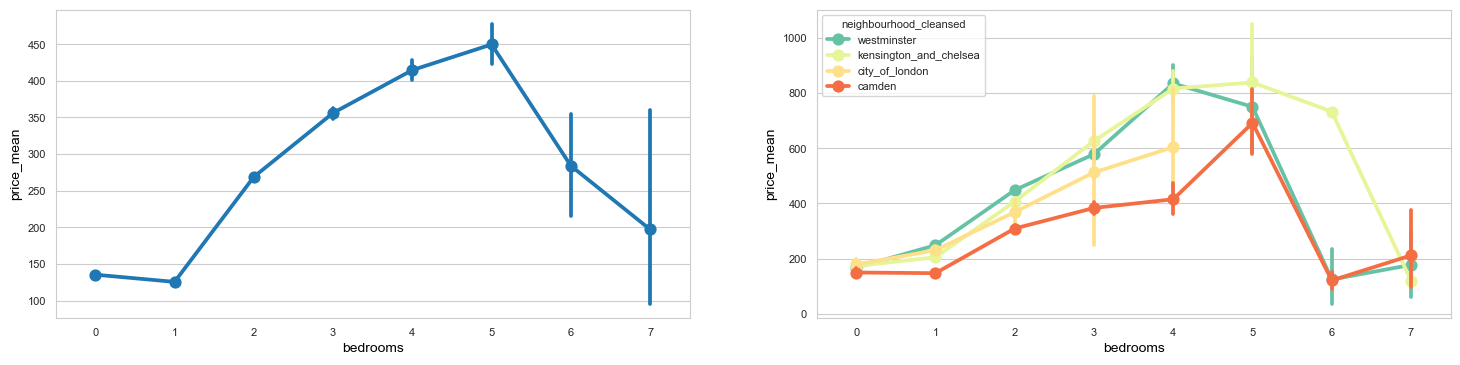

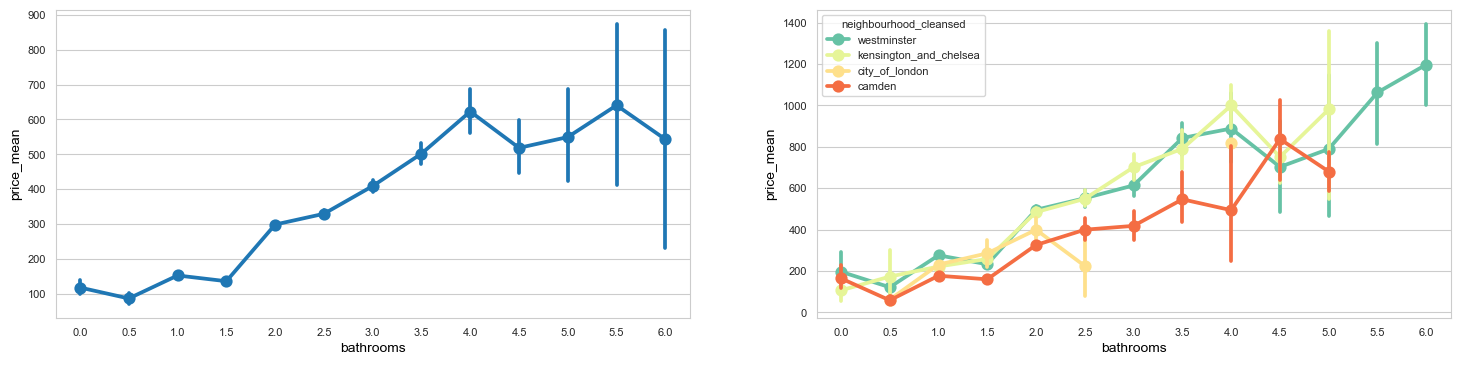

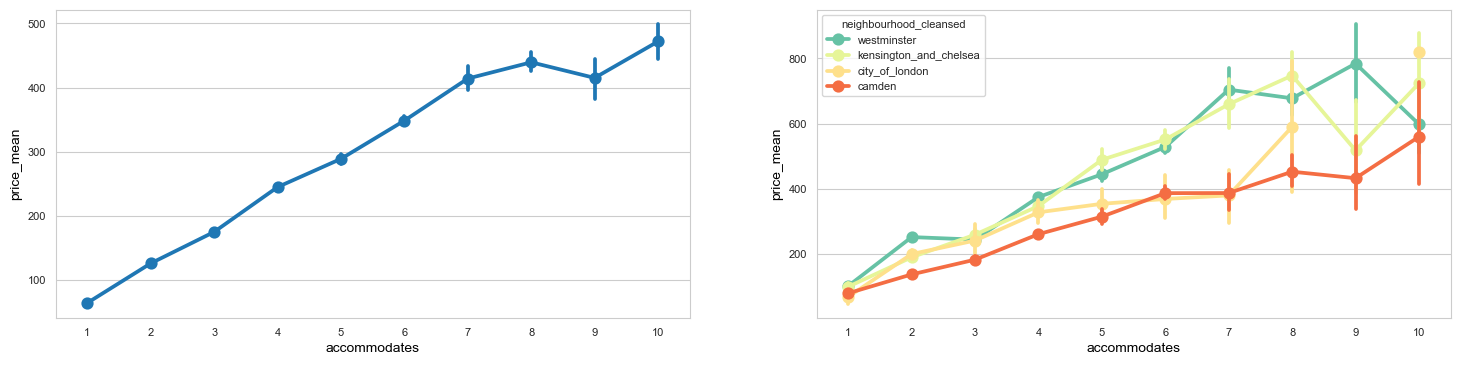

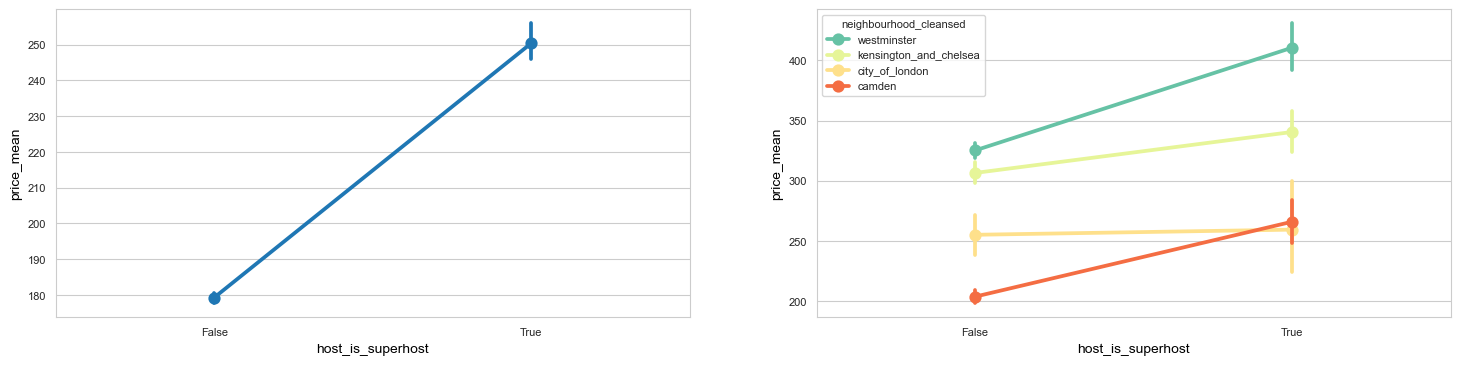

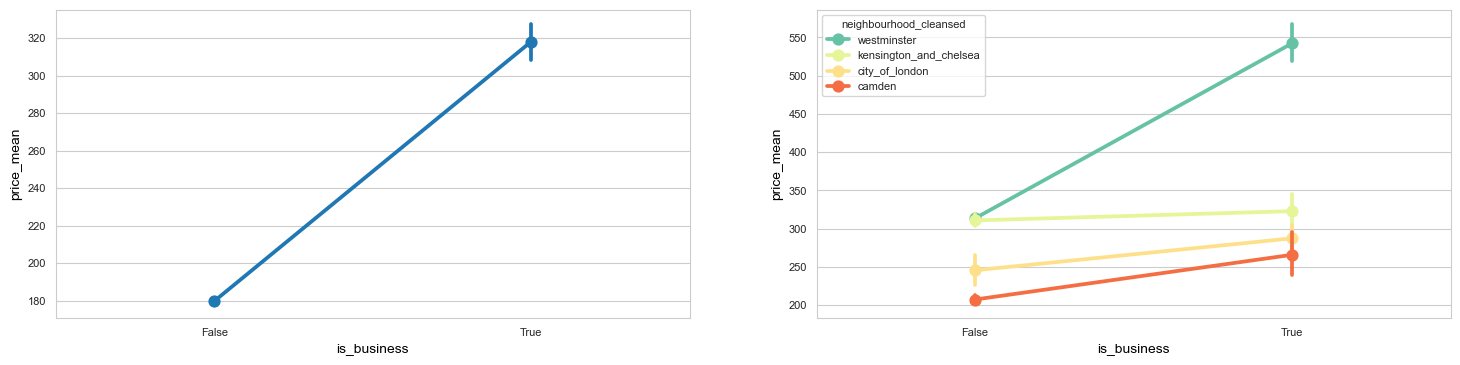

In [29]:
# Interaction with neighbourhood
cat = listing_clean.groupby('neighbourhood_cleansed')['price_mean'].mean().sort_values(ascending=False)
hue_order = list(cat.index)

for col in ['bedrooms', 'bathrooms', 'accommodates', 'host_is_superhost', 'is_business']:          

    plt.figure(figsize=(18,4))
    plt.subplot(1,2,1)
    sns.pointplot(data=listing_clean, x=col, y="price_mean")

    plt.subplot(1,2,2)
    sns.pointplot(data=listing_clean, x=col, y="price_mean", hue='neighbourhood_cleansed', hue_order=hue_order[:4], palette='Spectral_r')
    # plt.legend(bbox_to_anchor=(1,1), loc='upper left')

/var/folders/4p/r9m3gynn3wj6h4yh4_lwz5fw0000gn/T/ipykernel_47150/235346095.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cat = listing_clean.groupby(col)['price_mean'].mean().sort_values(ascending=False)


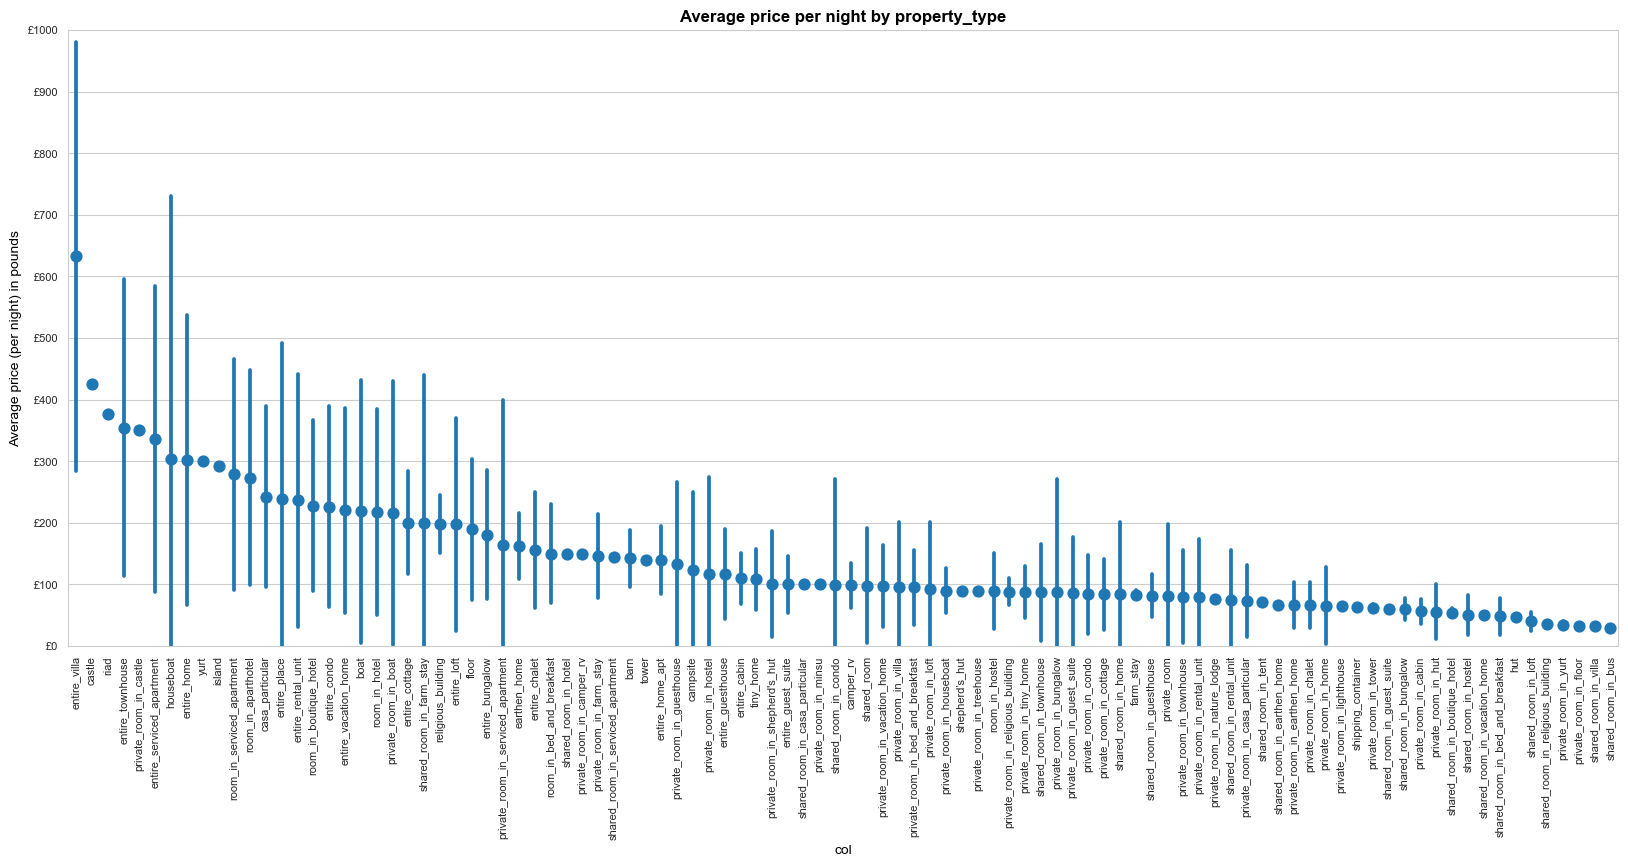

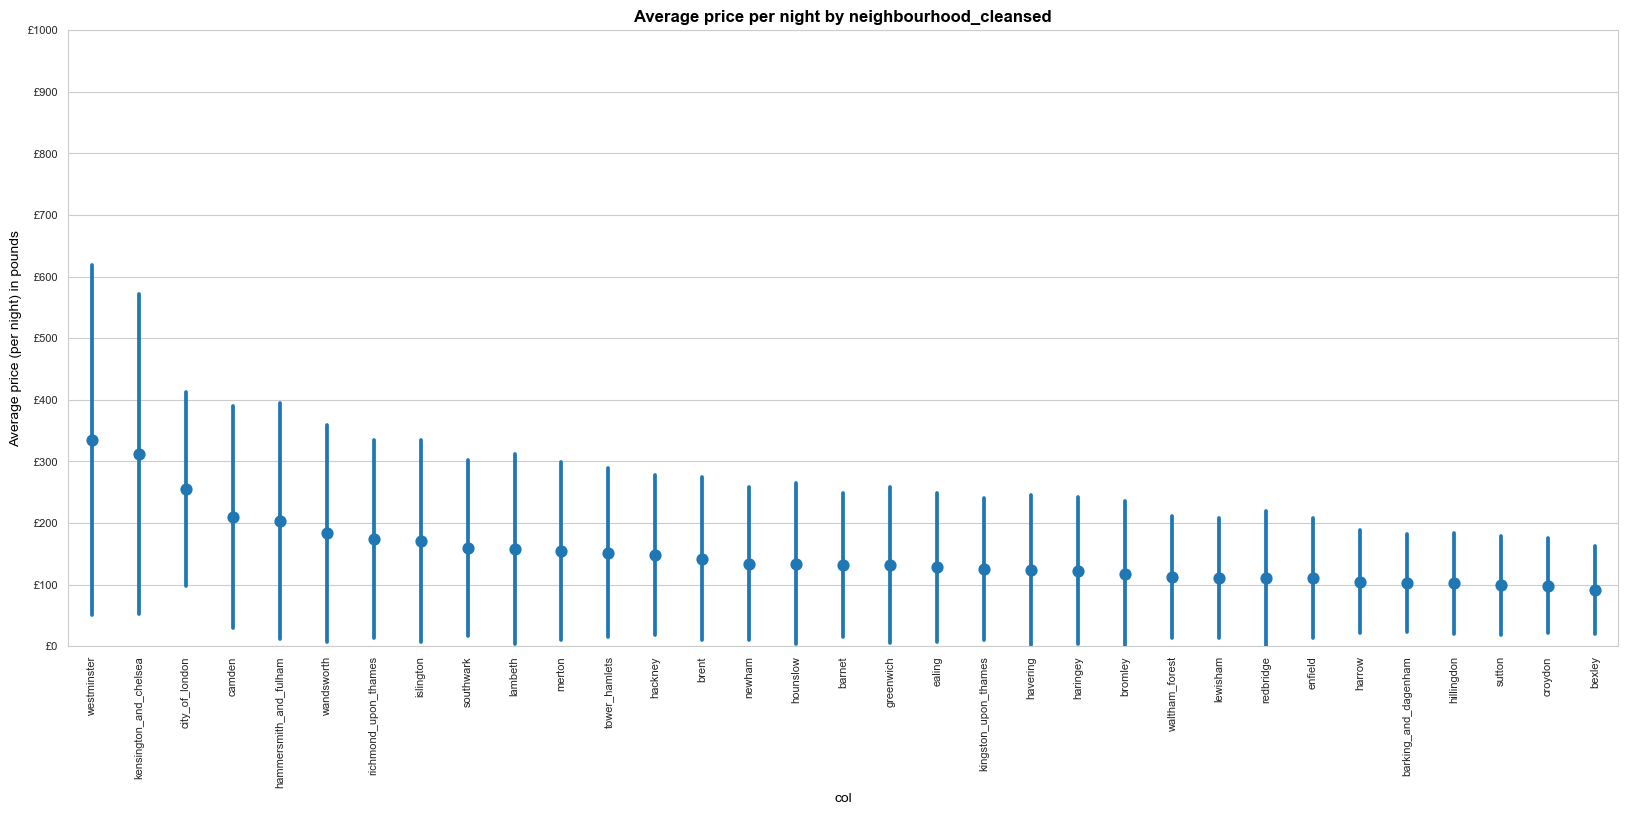

In [30]:
for col in ['property_type', 'neighbourhood_cleansed']:

    try:
        cat = listing_clean.groupby(col)['price_mean'].mean().sort_values(ascending=False)
        order = list(cat.index)

        plt.figure(figsize=(20,8))
        g = sns.pointplot(data=listing_clean, x=col, y='price_mean', errorbar='sd', linestyles="", marker='o', order=order)
        plt.title('Average price per night by {}'.format(col))
        plt.ylabel('Average price (per night) in pounds')
        plt.xlabel('col')

        plt.xticks(rotation=90)
        plt.ylim(0,1000)
        yticks = np.arange(0, 1100, 100)
        ylabels = ['£{:1.0f}'.format(tick) for tick in yticks] 
        plt.yticks(yticks, ylabels)

        plt.show()
    except:
        pass
        

**Observation**:
- slopes do not match, we will need an interaction term

### Cleaning

In [31]:
# def clean_data(df, y_feature='price_mean', random_state=88):
#     '''
#     INPUT
#     df - pandas dataframe 
    
#     OUTPUT
#     X - A matrix holding all of the variables you want to consider when predicting the response
#     y - the corresponding response vector
    
#     This function cleans df using the following steps to produce X and y:
#     1. Drop all the rows with no salaries
#     2. Create X as all the columns that are not the Salary column
#     3. Create y as the Salary column
#     4. Drop the Salary, Respondent, and the ExpectedSalary columns from X
#     5. For each numeric variable in X, fill the column with the mean value of the column.
#     6. Create dummy columns for all the categorical variables in X, drop the original columns
#     '''

#     # Drop rows with missing values in y-feature to be predicted
#     df = df.dropna(subset=[y_feature], axis=0)   

#     numerical_vars = list(df.select_dtypes(include='number').copy().columns)
#     numerical_vars.remove('price_mean')

#     # Dummy the categorical variables
#     cat_vars = list(df.select_dtypes(include=['object', 'bool']).copy().columns)
#     print('dummy vars {}'.format(cat_vars))
#     if len(cat_vars) > 0:
#         df = pd.get_dummies(data=df, 
#                             columns=cat_vars, 
#                             dummy_na=False, 
#                             prefix_sep='_', 
#                             drop_first=True)

#     # remove spaces from column names 
#     df.columns = df.columns.str.replace(' ', '_', regex=False).str.lower()
    
#     # restrict the values to be predicted to a min / max range
#     minimum_before = list(df.iloc[:, :].min(axis=0))
#     maximum_after = list(df.iloc[:, :].max(axis=0))

#     # impute missing values
#     imputer = IterativeImputer(random_state=random_state,
#                                imputation_order='descending',
#                                n_nearest_features=None,
#                                initial_strategy='mean',
#                                max_iter=30,
#                                min_value=minimum_before,
#                                max_value=maximum_after,
#                                skip_complete=True,
#                                tol=1000, 
#                                verbose=1)

#     df[:] = imputer.fit_transform(df) 

#     # prepare X and y datasets
#     y = df[y_feature]  
#     X = df.drop(y_feature, axis=1)

#     # scale numeric data
#     scaler = StandardScaler()
#     X[numerical_vars] = scaler.fit_transform(X[numerical_vars])        
    
#     return X, y, scaler

In [32]:
#Use the function to create X and y
# X_lm, y_lm, scaler_lm = clean_data(listing_clean.copy(deep=True), y_feature='price_mean')   

In [33]:
# print(X.shape)
# try:
#     X.drop('neighbourhood_cleansed_Westminster', axis=1, inplace=True)    
# except:
#     pass
# print(X.shape)

In [34]:
# X.head()

### Modelling

In [35]:
# def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=88, plot=True):
#     '''
#     INPUT
#     X - pandas dataframe, X matrix
#     y - pandas dataframe, response variable
#     cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
#     test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
#     random_state - int, default 42, controls random state for train_test_split
#     plot - boolean, default 0.3, True to plot result

#     OUTPUT
#     r2_scores_test - list of floats of r2 scores on the test data
#     r2_scores_train - list of floats of r2 scores on the train data
#     lm_model - model object from sklearn
#     X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
#     '''
#     r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    
#     reduce_X = X
    
# #     y = y.apply(lambda x: np.log10(x+1))
    
#     for cutoff in cutoffs:
#         print('start of cutoff {}'.format(cutoff))

#         #reduce X matrix
# #         reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
# #         num_feats.append(reduce_X.shape[1])
        
#         #split the data into train and test
#         X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

#         #fit the model and obtain pred response
#         lm_model = LinearRegression()
#         lm_model.fit(X_train, y_train)
#         y_test_preds = lm_model.predict(X_test)
#         y_train_preds = lm_model.predict(X_train)

#         #append the r2 value from the test set
#         r2_scores_test.append(r2_score(y_test, y_test_preds))
#         r2_scores_train.append(r2_score(y_train, y_train_preds))
#         results[str(cutoff)] = r2_score(y_test, y_test_preds)

#     if plot:
#         plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
#         plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
#         plt.xlabel('Number of Features')
#         plt.ylabel('Rsquared')
#         plt.title('Rsquared by Number of Features')
#         plt.legend(bbox_to_anchor=(1,1), loc='upper left')
#         plt.show()

#     print('building final model')
#     best_cutoff = max(results, key=results.get)

#     #reduce X matrix
# #     reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
# #     num_feats.append(reduce_X.shape[1])

#     #split the data into train and test
#     X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size=test_size, random_state=random_state)

#     #fit the model
#     lm_model = LinearRegression()
#     lm_model.fit(X_train, y_train)

#     return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test

In [36]:
# #cutoffs here pertains to the variability especially in dummy variables. 
# #If there are too little 1's in for example property type dummy variables, there is not enough variabilty for prediction
# #Therefore, lower values for the cutoff provides more predictors in the model.
# cutoffs = [1]

# r2_scores_test, r2_scores_train, lm_model, X_train_lm, X_test_lm, y_train_lm, y_test_lm = find_optimal_lm_mod(X_lm, y_lm, cutoffs, plot=False)
# print('R2 scores train {}'.format(r2_scores_train))
# print('R2 scores test {}'.format(r2_scores_test))

In [37]:
# listing_clean.room_type.unique()

# Pre-processing

In [38]:
# cleaning data / preprocessing step

def make_preprocessor(df, target='price_mean'):

    # we want different approaches for numeric vs categorical features
    numerical_features = df.select_dtypes(include='number').columns.tolist() 
    numerical_features.remove(target)   
    print(numerical_features)
    categorical_features = df.select_dtypes(exclude='number').columns.tolist() 
    print(categorical_features)    


    # Iterative imputer: restrict the values to be predicted to a min / max range
    minimum_before_numeric = list(df.loc[:, numerical_features].min(axis=0))
    maximum_after_numeric = list(df.loc[:, numerical_features].max(axis=0))
#     print(minimum_before_numeric)
#     print(maximum_after_numeric)


    numerical_preprocessor = Pipeline(steps=[
#         ('impute', IterativeImputer(initial_strategy='median', max_iter=3, skip_complete=True, 
#                                     verbose=0, n_nearest_features=None, imputation_order='descending', 
#                                     random_state=random_state)),  
        ('impute', SimpleImputer(strategy='median')),
    #     (make_column_selector(dtype_include=np.number)),
        ('scale', StandardScaler())
    ])


    categorical_preprocessor = Pipeline(steps=[
        ('one-hot', OneHotEncoder(dtype='int', drop="if_binary", handle_unknown='infrequent_if_exist', sparse_output=False, min_frequency=25)),    
#         ('impute', IterativeImputer(initial_strategy='most_frequent', max_iter=3, skip_complete=True, 
#                                     verbose=0, n_nearest_features=None, imputation_order='descending', 
#                                     random_state=random_state)),     

    ])

    preprocessor = ColumnTransformer(transformers=[

        ('number', numerical_preprocessor, numerical_features),
        ('category', categorical_preprocessor, categorical_features),
    #     ('selector', make_column_selector(pattern=f'^(?{cols})'), cols)   
    #     ('selector', make_column_selector(dtype_include=np.number), cols)


    ], 
            verbose_feature_names_out=False, 
            remainder = 'passthrough'                                                         
    #         remainder='drop',
    )
    
    df_transformed = preprocessor.fit_transform(df)
    df_transformed = pd.DataFrame(df_transformed, columns=list(preprocessor.get_feature_names_out()), index=df.index)
    
    return df_transformed


In [39]:
test = listing_clean.groupby('property_type').agg(count=('property_type','count'),
                                                  price=('price_mean', 'mean'))
test = test.sort_values(by='count', ascending=False)
test

/var/folders/4p/r9m3gynn3wj6h4yh4_lwz5fw0000gn/T/ipykernel_47150/1587895923.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  test = listing_clean.groupby('property_type').agg(count=('property_type','count'),


count       price
property_type                                        
entire_rental_unit                  24064  236.783411
private_room_in_rental_unit          9918   79.354507
entire_condo                         8513  226.482556
private_room_in_home                 8302   65.711877
entire_home                          5431  301.627325
private_room_in_condo                3149   84.232137
entire_serviced_apartment            1987  335.753397
private_room_in_townhouse            1174   79.955707
entire_townhouse                      873  354.831615
private_room_in_bed_and_breakfast     526   95.471483
room_in_hotel                         499  217.551102
entire_loft                           323  197.761610
private_room_in_guesthouse            306  132.581699
room_in_boutique_hotel                269  227.888476
entire_guesthouse                     180  117.550000
entire_guest_suite                    168  100.261905
private_room_in_serviced_apartment    166  164.566265
shared_room_in_rental_unit            153   75.111111
private_room_in_guest_suite           149   86.818792
private_room_in_loft                  146   92.219178
room_in_aparthotel                    132  273.590909
private_room_in_casa_particular       120   73.375000
entire_vacation_home                   97  220.329897
room_in_serviced_apartment             95  278.800000
shared_room_in_home                    78   83.782051
private_room                           72   81.138889
private_room_in_bungalow               61   87.278689
shared_room_in_hostel                  55   51.036364
entire_cottage                         55  200.254545
private_room_in_vacation_home          52   97.134615
private_room_in_hostel                 46  117.630435
entire_bungalow                        45  181.133333
entire_place                           44  239.340909
boat                                   40  219.025000
shared_room_in_condo                   33   98.909091
room_in_bed_and_breakfast              30  150.100000
tiny_home                              26  108.307692
entire_villa                           26  632.500000
private_room_in_cottage                24   84.166667
room_in_hostel                         18   89.500000
entire_cabin                           17  109.764706
private_room_in_villa                  14   96.500000
shared_room_in_bed_and_breakfast       12   48.583333
private_room_in_tiny_home              12   87.916667
camper_rv                              11   98.818182
houseboat                              10  304.300000
shared_room_in_guesthouse               8   81.375000
casa_particular                         8  242.750000
entire_home_apt                         7  139.571429
entire_chalet                           7  155.714286
private_room_in_cabin                   6   56.500000
shared_room_in_townhouse                6   87.666667
private_room_in_religious_building      5   88.600000
private_room_in_houseboat               4   90.250000
floor                                   4  189.500000
private_room_in_earthen_home            4   66.250000
private_room_in_boat                    3  216.000000
religious_building                      3  198.000000
private_room_in_yurt                    3   34.000000
private_room_in_chalet                  3   66.000000
campsite                                3  123.333333
shared_room                             3   98.333333
shared_room_in_bungalow                 3   60.000000
farm_stay                               3   83.666667
shared_room_in_boutique_hotel           2   54.500000
shared_room_in_farm_stay                2  200.000000
shared_room_in_loft                     2   40.000000
barn                                    2  142.500000
private_room_in_tower                   2   61.500000
private_room_in_shepherd's_hut          2  101.000000
private_room_in_farm_stay               2  146.500000
earthen_home                            2  162.500000
private_room_in_hut                     

In [40]:
# listing_clean.drop('price_group', axis=1, inplace=True)
listing_transformed = make_preprocessor(listing_clean.copy(deep=True))
listing_transformed.shape

['accommodates', 'bedrooms', 'bathrooms', 'minimum_minimum_nights', 'calculated_host_listings_count', 'host_years_active', 'availability_90', 'review_scores_location', 'price_group']
['host_is_superhost', 'private_bathroom', 'host_same_location', 'is_business', 'neighbourhood_cleansed', 'property_type']


(67647, 86)

In [41]:
#split the data into train and test
y = listing_transformed['price_mean'].copy()
X = listing_transformed.drop('price_mean', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=X['is_business_True'])

Mutual Information (MI) is a way to how every feature interact with the target variable in this case 'price'. Here to interact means how a particular feature changes the target variable. The higher the score, the stronger the interaction.
Note: Mutual Information only works with numerrical data

In [42]:
# from sklearn.feature_selection import mutual_info_regression

# def get_mi_score(X, y):
#     mi = mutual_info_regression(X, y, random_state=10)
#     mi = pd.Series(mi, index=X.columns).sort_values(ascending=False)
#     return mi


# # display Mutual Information scores of the features
# mi_score = get_mi_score(X, y)


# plt.figure(figsize=(6, 20))
# ax = sns.barplot(y=mi_score.index[1:], x=mi_score[1:])
# ax.set_title('MI scores', fontdict={'fontsize': 16})
# plt.show()

### Test for multicollinearity

In [43]:
#gather features
# vip_features = " + ".join(X_train.columns)
# vip_features

In [44]:
# merge X and y as required by statsmodels
# vip_df = X_train.merge(y_train, left_index=True, right_index=True)

In [45]:
# sm_y, sm_X = dmatrices('price_mean ~' + vip_features, vip_df, return_type='dataframe')
# vif = pd.DataFrame()
# vif['VIF Factor'] = [variance_inflation_factor(sm_X.values, i) for i in range(sm_X.shape[1])]
# vif['features'] = sm_X.columns
# vif

# Modelling Step 1 - Using Ridge

In [46]:
# modelling

# numpy.logspace(start, stop, num=50, endpoint=True, base=10.0, dtype=None, axis=0)

# alphas = np.logspace(start=1, stop=10, num=20)  # alpha values to be chosen from by cross-validation

model = Pipeline(
    [
#         ("preprocess", preprocessor),
        ('selector', VarianceThreshold(0)),
#         ("regressor", TransformedTargetRegressor(regressor=RidgeCV(alphas=alphas), func=np.log10, inverse_func=sp.special.exp10)), 
        ("regressor", TransformedTargetRegressor(regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10)),           
#         ("regressor", TransformedTargetRegressor(regressor=LassoCV(alphas=alphas, max_iter=100_000), func=np.log10, inverse_func=sp.special.exp10)),         
#         ("regressor", TransformedTa5getRegressor(regressor=LinearRegression(), func=np.log10, inverse_func=sp.special.exp10)),           

    ]
)

In [47]:
model.fit(X_train, y_train)  

Pipeline(steps=[('selector', VarianceThreshold(threshold=0)),
                ('regressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(alpha=1e-10)))])

First we check which value of $\alpha$ has been selected.

In [48]:
model[-1].regressor_.alpha

1e-10

First we check which value of $\alpha$ has been selected.

# Evaluation

In [49]:
# training scores
y_train_preds = model.predict(X_train)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_train, y_train_preds))
print('Mean Absolute Error: ', format(mean_absolute_error(y_train, y_train_preds)))
# The coefficient of determination: 1 is perfect prediction
print("R-squared: %.2f" % r2_score(y_train, y_train_preds))


# with room and property type, bedrooms, bathrooms and accommodates, with neighborhood
# Mean squared error: 21493.38
# Mean Absolute Error:  70.53691975387208
# R-squared: 0.53


# same above, dropped room_type
# Mean squared error: 15148.33
# Mean Absolute Error:  60.87482989331954
# R-squared: 0.67

Mean squared error: 10571.59
Mean Absolute Error:  55.70819365956994
R-squared: 0.71


In [50]:
# testing scores
y_test_preds = model.predict(X_test)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_test_preds))
print('Mean Absolute Error: ', format(mean_absolute_error(y_test, y_test_preds)))
print('Median Absolute Error: ', format(median_absolute_error(y_test, y_test_preds)))
# The coefficient of determination: 1 is perfect prediction
print("R-squared: %.2f" % r2_score(y_test, y_test_preds))

# with room and property type, bedrooms, bathrooms and accommodates, with neighborhood
# Mean squared error: 22420.59
# Mean Absolute Error:  71.53369146028079
# R-squared: 0.51

# same above, dropped room_type
# Mean squared error: 15903.26
# Mean Absolute Error:  62.423487998915014
# R-squared: 0.65

Mean squared error: 10226.13
Mean Absolute Error:  55.334618947059845
Median Absolute Error:  28.280365699386493
R-squared: 0.72


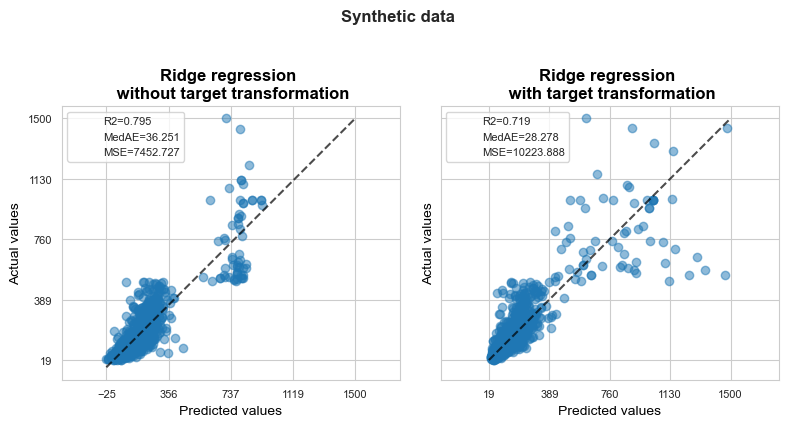

In [87]:
# Effect of transforming the targets in regression model

def compute_score(y_true, y_pred):
    return {
        "R2": f"{r2_score(y_true, y_pred):.3f}",
        "MedAE": f"{median_absolute_error(y_true, y_pred):.3f}",
        "MSE": f"{mean_squared_error(y_true, y_pred):.3f}",
    }

f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

ridge_no_trans = Ridge().fit(X_train, y_train)
y_pred_notrans = ridge_no_trans.predict(X_test)

ridge_cv_with_trans_target = TransformedTargetRegressor(
    regressor=Ridge(), func=np.log10, inverse_func=sp.special.exp10).fit(X_train, y_train)
#     regressor=Ridge(), func=np.log1p, inverse_func=np.expm1
# ).fit(X_train, y_train)
y_pred_with_trans_target = ridge_cv_with_trans_target.predict(X_test)

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_notrans,
    kind="actual_vs_predicted",
    ax=ax0,
    scatter_kwargs={"alpha": 0.5},
)
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_with_trans_target,
    kind="actual_vs_predicted",
    ax=ax1,
    scatter_kwargs={"alpha": 0.5},
)

# Add the score in the legend of each axis
for ax, y_pred in zip([ax0, ax1], [y_pred_notrans, y_pred_with_trans_target]):
    for name, score in compute_score(y_test, y_pred).items():
        ax.plot([], [], " ", label=f"{name}={score}")
    ax.legend(loc="upper left")

ax0.set_title("Ridge regression \n without target transformation")
ax1.set_title("Ridge regression \n with target transformation")
f.suptitle("Synthetic data", y=1.05)
plt.tight_layout()

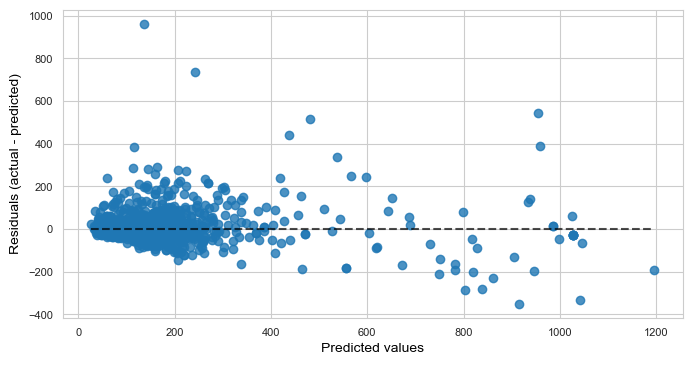

In [52]:
disp = PredictionErrorDisplay.from_estimator(model, X_test, y_test)

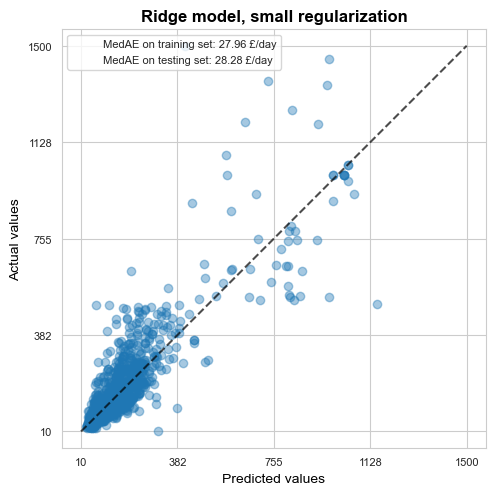

In [53]:
mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} £/day",
    "MedAE on testing set": f"{mae_test:.2f} £/day",
}

_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_true=y_test, y_pred=y_test_preds, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.4}
)
ax.set_title("Ridge model, small regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

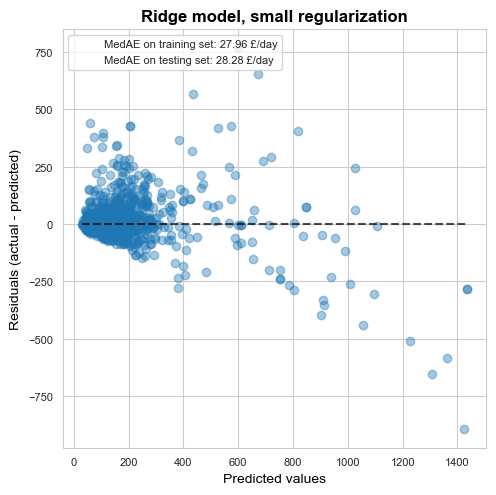

In [54]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_true=y_test, y_pred=y_test_preds, ax=ax, scatter_kwargs={"alpha": 0.4}
)
ax.set_title("Ridge model, small regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

In [55]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
#     df_results = df_results.reset_index()
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.0
Residuals are not normally distributed


/opt/anaconda3/envs/ds_udacity_projects/lib/python3.10/site-packages/statsmodels/stats/_adnorm.py:67: RuntimeWarning: divide by zero encountered in log1p
  s = np.sum((2 * i[sl1] - 1.0) / nobs * (np.log(z) + np.log1p(-z[sl2])),


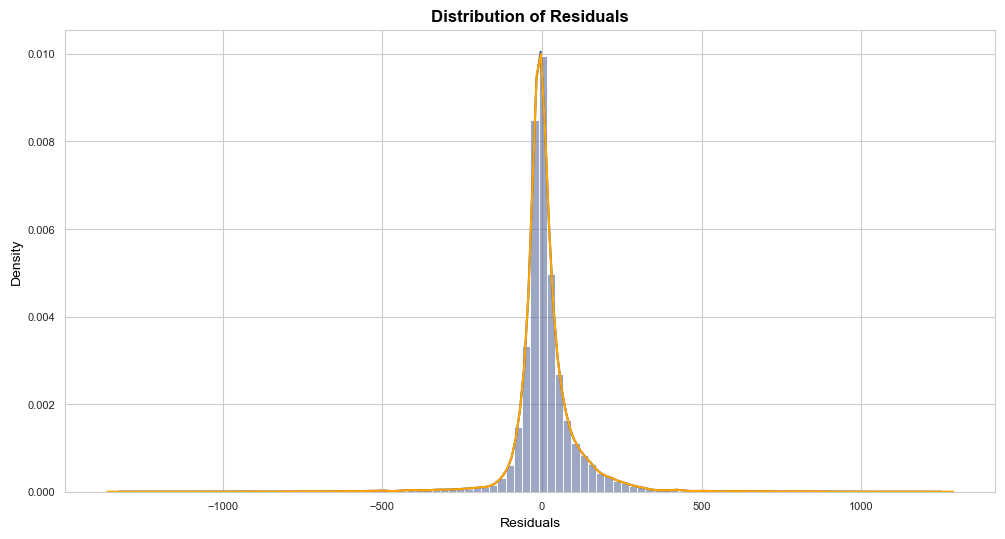


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables


In [56]:
def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    from statsmodels.stats.diagnostic import normal_ad
    print('Assumption 2: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, label)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.subplots(figsize=(12,6))
    plt.title('Distribution of Residuals')
    
    ax = sns.histplot(df_results['Residuals'], bins=100, stat='density', kde=True, color=BASE_COLOR)
    sns.kdeplot(df_results['Residuals'], color='orange', ax=ax)
    
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')
        
normal_errors_assumption(model, X_train, y_train)        

Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


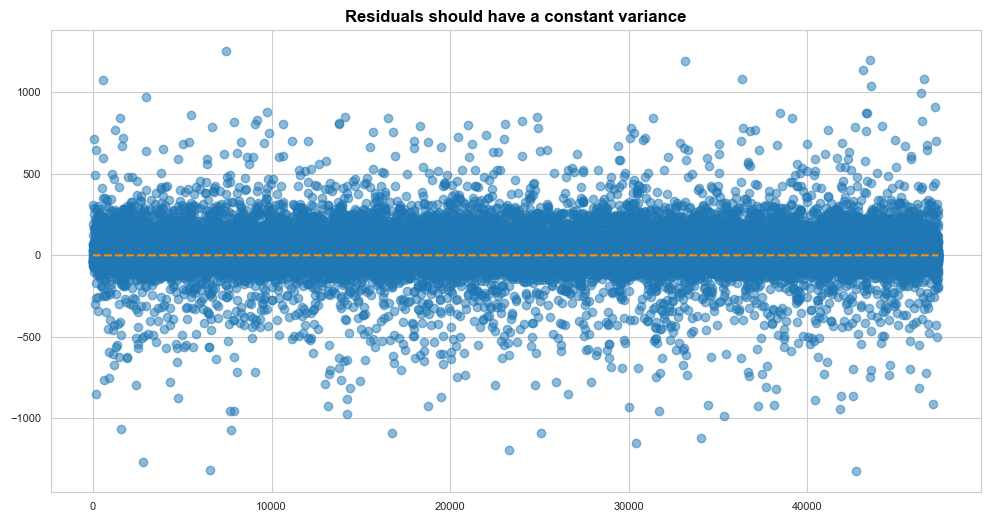

In [57]:
def homoscedasticity_assumption(model, features, label):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print('Assumption 5: Homoscedasticity of Error Terms', '\n')
    
    print('Residuals should have relative constant variance')
        
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    df_results.reset_index(inplace=True)

    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot()  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
#     ax.spines['right'].set_visible(False)  # Removing the right spine
#     ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals should have a constant variance')
    plt.show()  
    
homoscedasticity_assumption(model, X_train, y_train) 

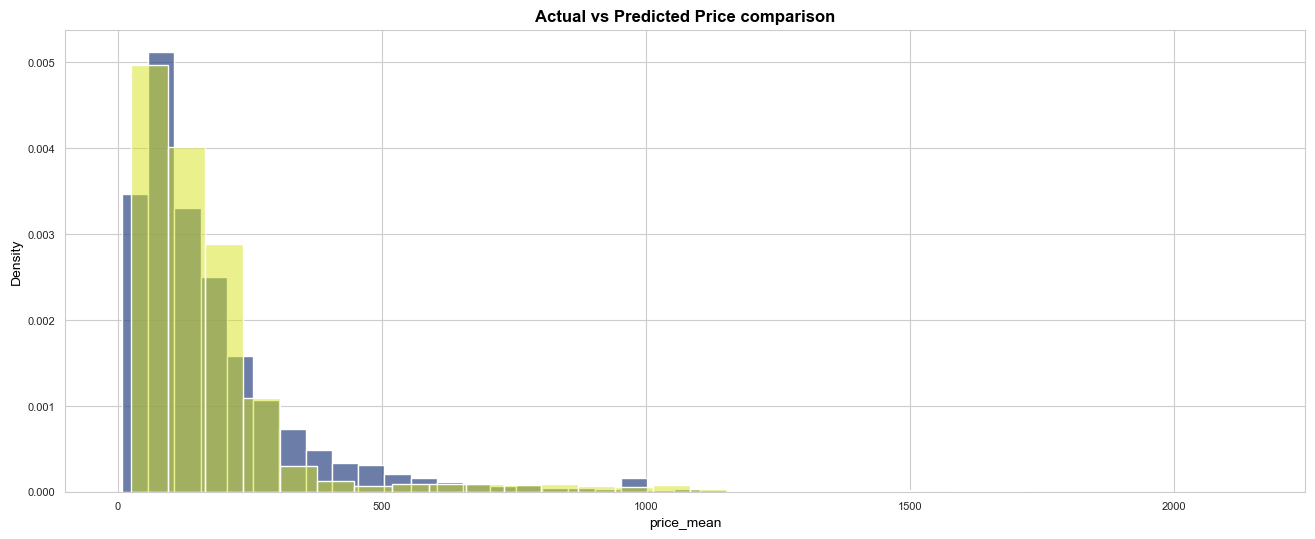

In [58]:
# Actual vs predicted price comparision
ax, fig = plt.subplots(figsize=(16,6), sharex=True)

xbins = np.arange(0, 1600, 100)

ax = sns.histplot(y_test, bins=30, stat='density', kde=False, color=BASE_COLOR, label='actual')
sns.histplot(y_test_preds, bins=30, stat='density', kde=False, color=BASE_COMPLEMENTRY, alpha=0.5, label='predicted', ax=ax)

# plt.xticks(xbins, xbins)
plt.title('Actual vs Predicted Price comparison')

plt.show()

# reset default plot formatting back as PairGrid change the defaults somehow
BASE_COLOR, BASE_HIGHLIGHT_INTENSE, BASE_HIGHLIGHT, BASE_COMPLEMENTRY, BASE_GREY, BASE_COLOR_ARR, BASE_COLOR_DEP, SYMBOLS = vs.set_plot_defaults()

In [59]:
def coef_weights(coefficients):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = feature_names = model[:-1].get_feature_names_out()
    coefs_df['coefs'] = model[-1].regressor_.coef_
    coefs_df['abs_coefs'] = abs(model[-1].regressor_.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    
    coefs_df = coefs_df.set_index('est_int')    
    
    return coefs_df

#Use the function
coef_df = coef_weights(model)


#A quick look at the top results
coef_df

coefs  abs_coefs
est_int                                                              
property_type_shared_room_in_hostel              -0.598957   0.598957
property_type_private_room                       -0.190577   0.190577
property_type_entire_serviced_apartment           0.182531   0.182531
neighbourhood_cleansed_city_of_london             0.181566   0.181566
property_type_entire_cottage                      0.174526   0.174526
neighbourhood_cleansed_westminster                0.166721   0.166721
property_type_private_room_in_home               -0.161384   0.161384
neighbourhood_cleansed_kensington_and_chelsea     0.159491   0.159491
property_type_room_in_aparthotel                  0.157271   0.157271
property_type_private_room_in_casa_particular    -0.154032   0.154032
property_type_entire_villa                        0.147128   0.147128
property_type_shared_room_in_home                -0.146817   0.146817
property_type_shared_room_in_rental_unit         -0.146130   0.146130
property_type_room_in_boutique_hotel              0.143814   0.143814
property_type_entire_condo                        0.142481   0.142481
property_type_private_room_in_rental_unit        -0.141752   0.141752
property_type_shared_room_in_condo               -0.141143   0.141143
property_type_entire_loft                         0.136859   0.136859
property_type_entire_townhouse                    0.135595   0.135595
neighbourhood_cleansed_bexley                    -0.134452   0.134452
property_type_entire_bungalow                     0.131961   0.131961
property_type_room_in_bed_and_breakfast           0.128026   0.128026
property_type_entire_home                         0.124240   0.124240
property_type_room_in_serviced_apartment          0.124203   0.124203
property_type_entire_vacation_home                0.124187   0.124187
property_type_entire_place                        0.121185   0.121185
property_type_room_in_hotel                       0.120067   0.120067
neighbourhood_cleansed_camden                     0.114759   0.114759
property_type_private_room_in_townhouse          -0.111399   0.111399
property_type_entire_rental_unit                  0.110485   0.110485
neighbourhood_cleansed_havering                  -0.109311   0.109311
neighbourhood_cleansed_sutton                    -0.106431   0.106431
property_type_private_room_in_hostel             -0.105762   0.105762
neighbourhood_cleansed_barking_and_dagenham      -0.101830   0.101830
price_group                                       0.097081   0.097081
neighbourhood_cleansed_croydon                   -0.094005   0.094005
property_type_boat                                0.090723   0.090723
neighbourhood_cleansed_hammersmith_and_fulham     0.089947   0.089947
property_type_private_room_in_bungalow           -0.085258   0.085258
neighbourhood_cleansed_islington                  0.081782   0.081782
property_type_private_room_in_condo              -0.080354   0.080354
accommodates                                      0.078919   0.078919
private_bathroom_True                             0.076474   0.076474
availability_90                                   0.074536   0.074536
neighbourhood_cleansed_harrow                    -0.073208   0.073208
neighbourhood_cleansed_bromley                   -0.071171   0.071171
neighbourhood_cleansed_enfield                   -0.066386   0.066386
neighbourhood_cleansed_hillingdon                -0.065931   0.065931
neighbourhood_cleansed_wandsworth                 0.064049   0.064049
property_type_private_room_in_guest_suite        -0.063990   0.063990
property_type_infrequent_sklearn                 -0.062745   0.062745
neighbourhood_cleansed_southwark                  0.061676   0.061676
property_type_private_room_in_bed_and_breakfast  -0.058380   0.058380
property_type_private_room_in_vacation_home      -0.057689   0.057689
neighbourhood_cleansed_redbridge                 -0.055253   0.055253
neighbourhood_cleansed_tower_hamlets              0.055039   0.

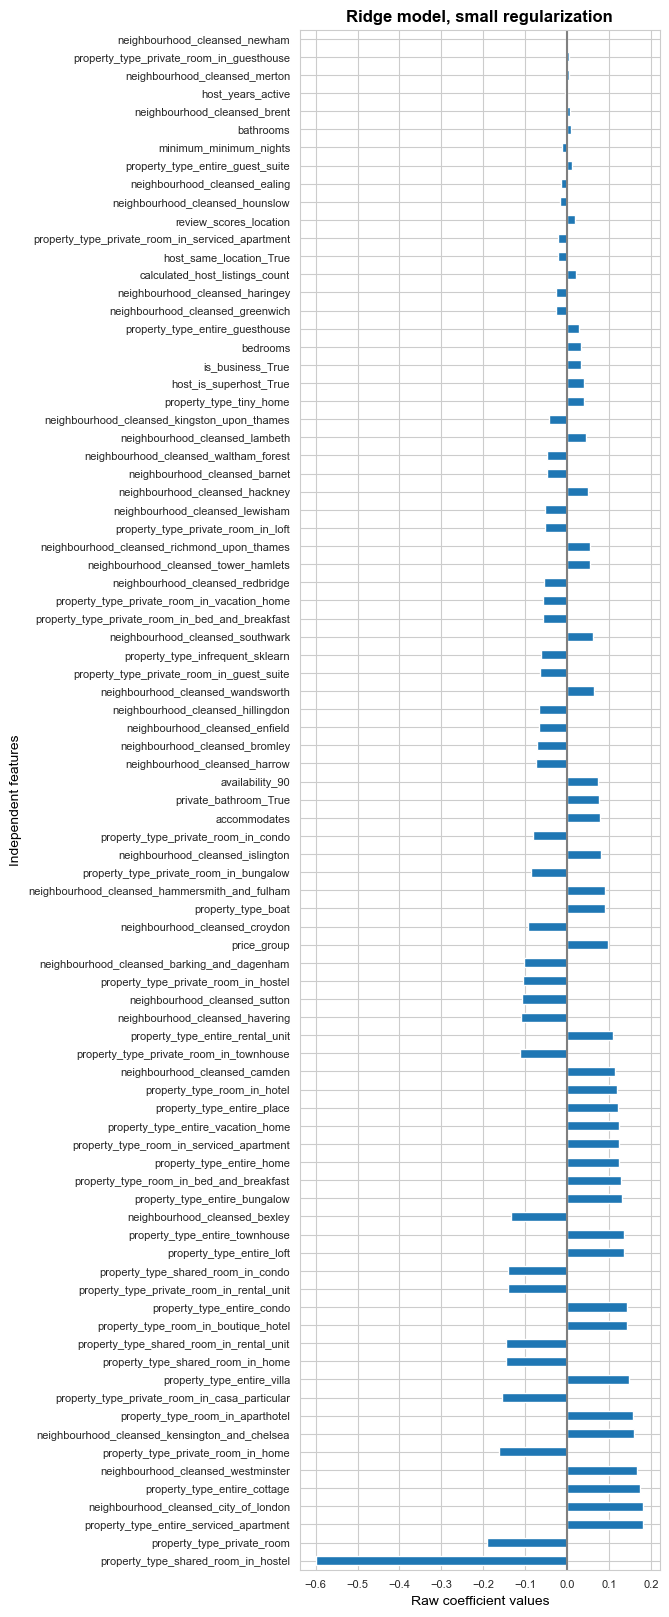

In [60]:
# ax, fig = plt.subplots(figsize=(6,20))

coef_df['coefs'].plot.barh(figsize=(6,20))
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.ylabel('Independent features')
plt.subplots_adjust(left=0.3)
plt.show()

Now that the coefficients have been scaled, we can safely compare them.

<div class="alert alert-danger"><h4>Warning</h4><p>Why does the plot above suggest that an increase in age leads to a
  decrease in wage? Why the `initial pairplot
  <marginal_dependencies>` is telling the opposite?</p></div>

The plot above tells us about dependencies between a specific feature and
the target when all other features remain constant, i.e., **conditional
dependencies**. An increase of the AGE will induce a decrease
of the WAGE when all other features remain constant. On the contrary, an
increase of the EXPERIENCE will induce an increase of the WAGE when all
other features remain constant.
Also, AGE, EXPERIENCE and EDUCATION are the three variables that most
influence the model.

## Checking the variability of the coefficients

We can check the coefficient variability through cross-validation:
it is a form of data perturbation (related to
[resampling](https://en.wikipedia.org/wiki/Resampling_(statistics))).

If coefficients vary significantly when changing the input dataset
their robustness is not guaranteed, and they should probably be interpreted
with caution.

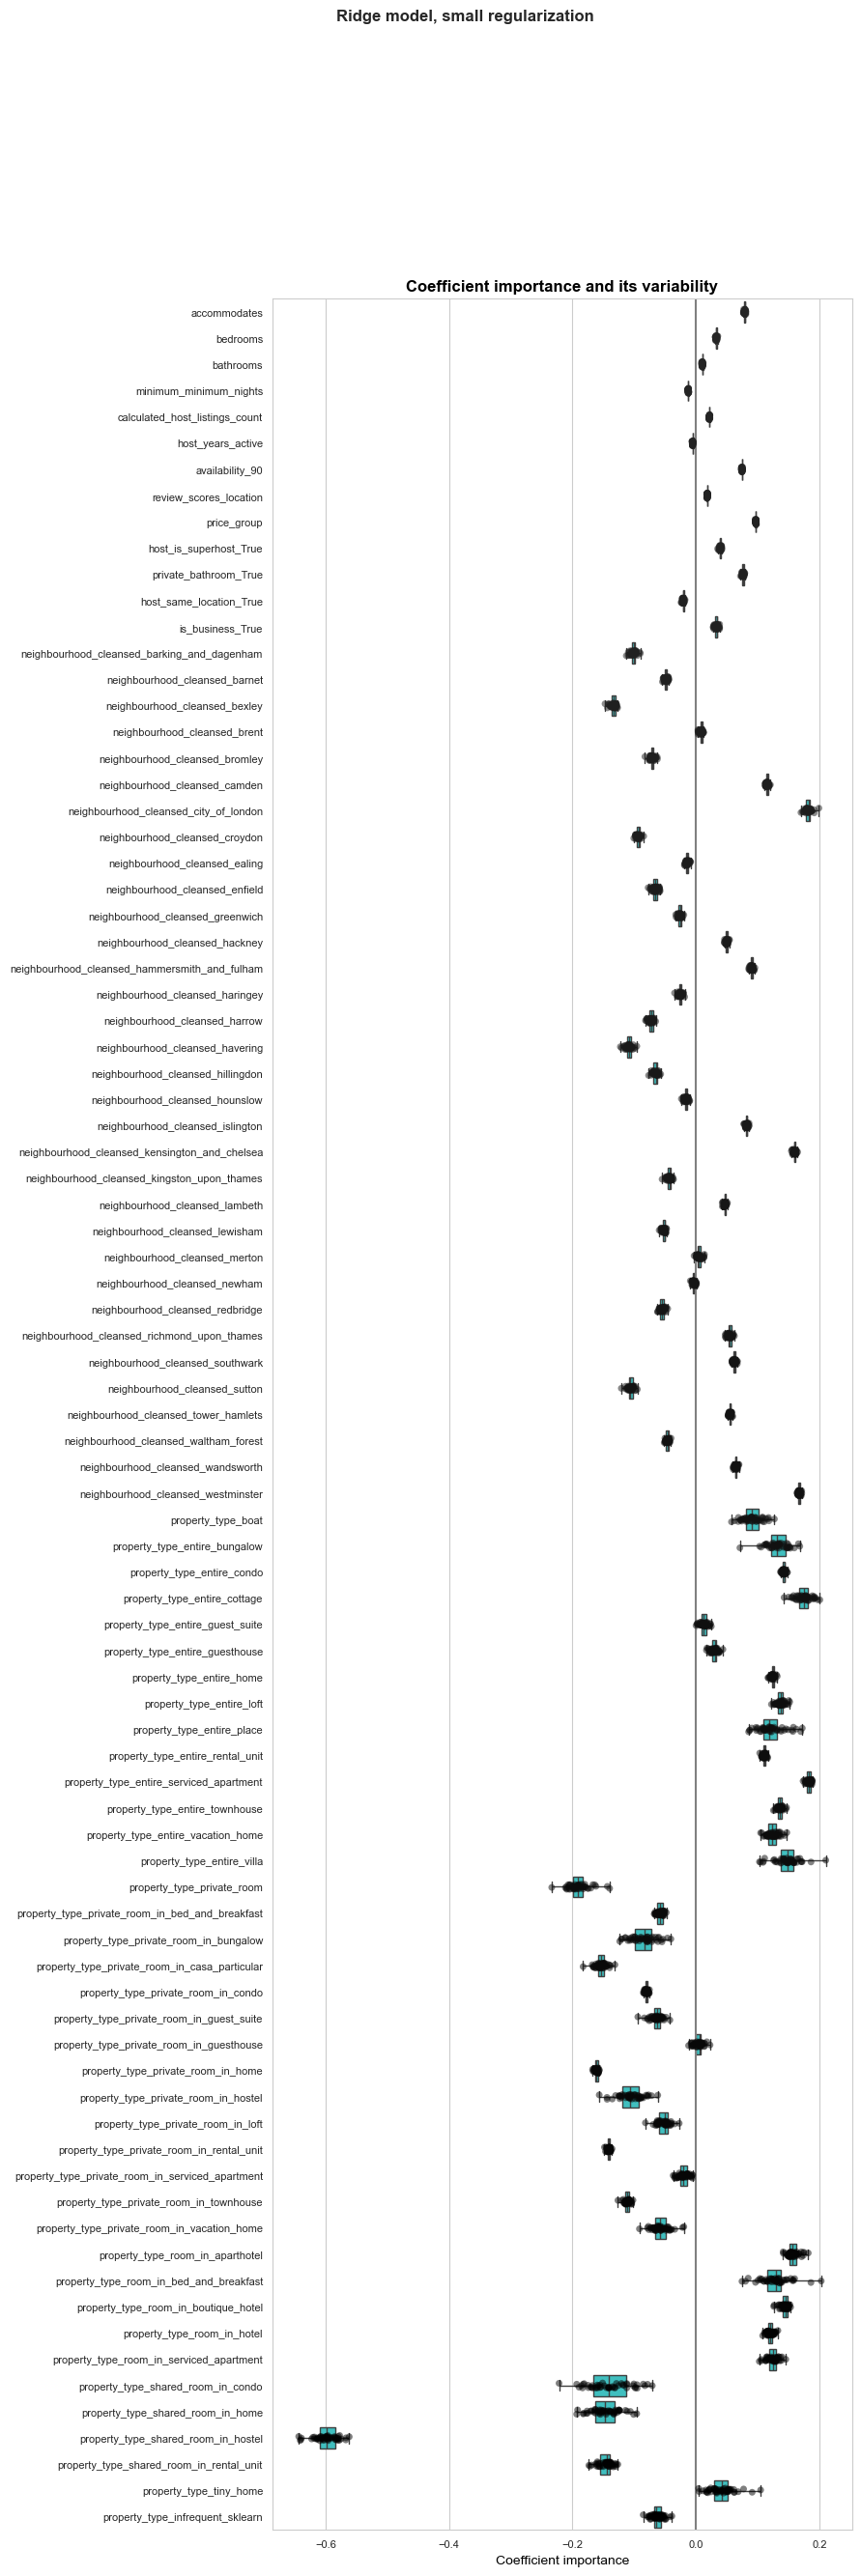

In [61]:
feature_names = model[:-1].get_feature_names_out()

cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=0)

cv_model = cross_validate(
    model,
    X_train,
    y_train,
    cv=cv,
    return_estimator=True,
    n_jobs=10,
)

coefs = pd.DataFrame(
    [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names
)

plt.figure(figsize=(10, 30))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.suptitle("Ridge model, small regularization")
plt.subplots_adjust(left=0.3)

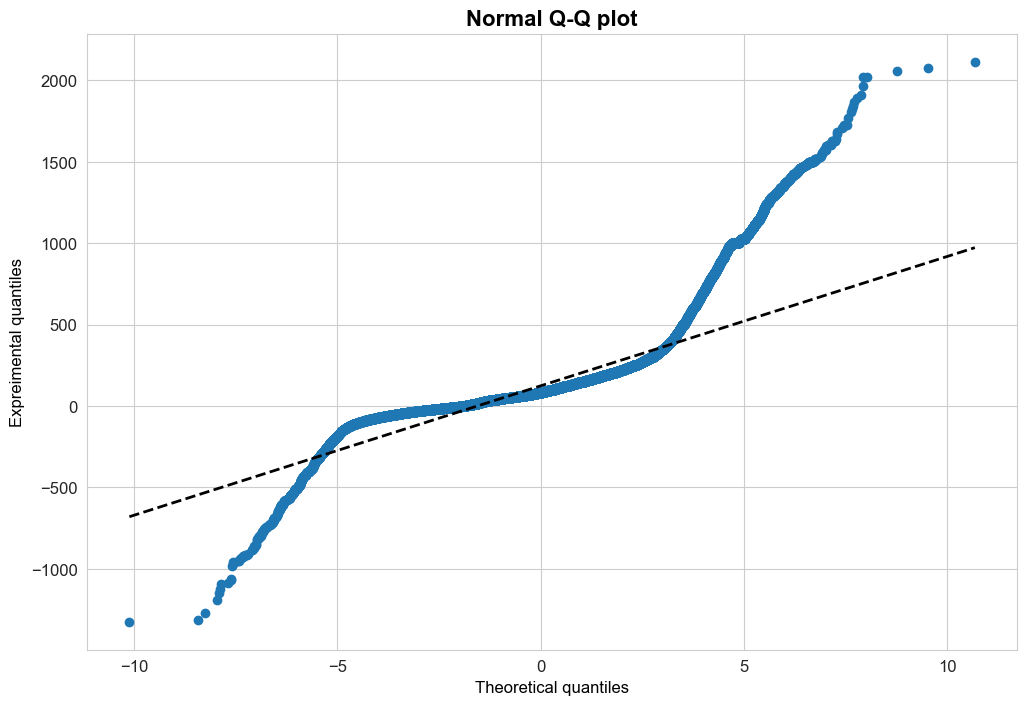

In [62]:
#Assess Q-Q plot
import numpy.random as random

# data=residuals.values.flatten()
data = calculate_residuals(model, X_train, y_train).values.flatten()
data.sort()

norm=random.normal(0,2,len(data))
norm.sort()
plt.figure(figsize=(12,8),facecolor='1.0')
plt.plot(norm,data,"o")

#generate a trend line as in http://widu.tumblr.com/post/43624347354/matplotlib-trendline
z = np.polyfit(norm,data, 1)
p = np.poly1d(z)
plt.plot(norm,p(norm),"k--", linewidth=2)
plt.title("Normal Q-Q plot", size=16)
plt.xlabel("Theoretical quantiles", size=12)
plt.ylabel("Expreimental quantiles", size=12)
plt.tick_params(labelsize=12)
plt.show()

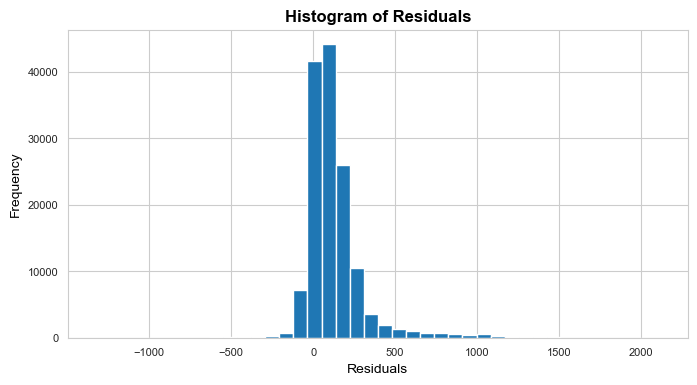

In [63]:
#HISTOGRAM OF RESIDUALS
x = calculate_residuals(model, X_train, y_train).values.flatten()

plt.title('Histogram of Residuals')
plt.hist(x, bins=40)
plt.ylabel('Frequency')
plt.xlabel('Residuals')
plt.show()

# Modelling Step 2 - Using Ridge CV

Lets get rid of interactions

In [64]:
# modelling

# numpy.logspace(start, stop, num=50, endpoint=True, base=10.0, dtype=None, axis=0)

alphas = np.logspace(start=-10, stop=10, num=21)  # alpha values to be chosen from by cross-validation

model = Pipeline(
    [
#         ("preprocess", preprocessor),
        ('selector', VarianceThreshold(0)),
        ("regressor", TransformedTargetRegressor(regressor=RidgeCV(alphas=alphas), func=np.log10, inverse_func=sp.special.exp10)), 
#         ("regressor", TransformedTargetRegressor(regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10)),           
#         ("regressor", TransformedTargetRegressor(regressor=LassoCV(alphas=alphas, max_iter=100_000), func=np.log10, inverse_func=sp.special.exp10)),         
#         ("regressor", TransformedTa5getRegressor(regressor=LinearRegression(), func=np.log10, inverse_func=sp.special.exp10)),           

    ]
)

In [65]:
_ = model.fit(X_train, y_train)  

First we check which value of $\alpha$ has been selected.

In [66]:
model[-1].regressor_.alpha_

1.0

First we check which value of $\alpha$ has been selected.

# Evaluation

In [67]:
# training scores
y_train_preds = model.predict(X_train)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_train, y_train_preds))
print('Mean Absolute Error: ', format(mean_absolute_error(y_train, y_train_preds)))
# The coefficient of determination: 1 is perfect prediction
print("R-squared: %.2f" % r2_score(y_train, y_train_preds))


# with room and property type, bedrooms, bathrooms and accommodates, with neighborhood
# Mean squared error: 21493.38
# Mean Absolute Error:  70.53691975387208
# R-squared: 0.53


# same above, dropped room_type
# Mean squared error: 15148.33
# Mean Absolute Error:  60.87482989331954
# R-squared: 0.67

Mean squared error: 10569.14
Mean Absolute Error:  55.707974663246766
R-squared: 0.71


In [68]:
# testing scores
y_test_preds = model.predict(X_test)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_test_preds))
print('Mean Absolute Error: ', format(mean_absolute_error(y_test, y_test_preds)))
print('Median Absolute Error: ', format(median_absolute_error(y_test, y_test_preds)))
# The coefficient of determination: 1 is perfect prediction
print("R-squared: %.2f" % r2_score(y_test, y_test_preds))

# with room and property type, bedrooms, bathrooms and accommodates, with neighborhood
# Mean squared error: 22420.59
# Mean Absolute Error:  71.53369146028079
# R-squared: 0.51

# same above, dropped room_type
# Mean squared error: 15903.26
# Mean Absolute Error:  62.423487998915014
# R-squared: 0.65

Mean squared error: 10223.89
Mean Absolute Error:  55.333036701373885
Median Absolute Error:  28.277817138493347
R-squared: 0.72


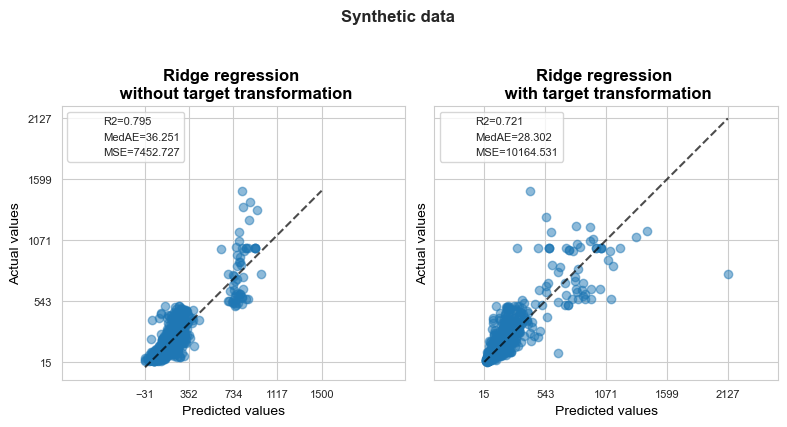

In [69]:
# Effect of transforming the targets in regression model

def compute_score(y_true, y_pred):
    return {
        "R2": f"{r2_score(y_true, y_pred):.3f}",
        "MedAE": f"{median_absolute_error(y_true, y_pred):.3f}",
        "MSE": f"{mean_squared_error(y_true, y_pred):.3f}",
    }

f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

ridge_cv = RidgeCV().fit(X_train, y_train)
y_pred_ridge = ridge_cv.predict(X_test)

ridge_cv_with_trans_target = TransformedTargetRegressor(
    regressor=RidgeCV(), func=np.log1p, inverse_func=np.expm1
).fit(X_train, y_train)
y_pred_ridge_with_trans_target = ridge_cv_with_trans_target.predict(X_test)

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_ridge,
    kind="actual_vs_predicted",
    ax=ax0,
    scatter_kwargs={"alpha": 0.5},
)
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_ridge_with_trans_target,
    kind="actual_vs_predicted",
    ax=ax1,
    scatter_kwargs={"alpha": 0.5},
)

# Add the score in the legend of each axis
for ax, y_pred in zip([ax0, ax1], [y_pred_ridge, y_pred_ridge_with_trans_target]):
    for name, score in compute_score(y_test, y_pred).items():
        ax.plot([], [], " ", label=f"{name}={score}")
    ax.legend(loc="upper left")

ax0.set_title("Ridge regression \n without target transformation")
ax1.set_title("Ridge regression \n with target transformation")
f.suptitle("Synthetic data", y=1.05)
plt.tight_layout()

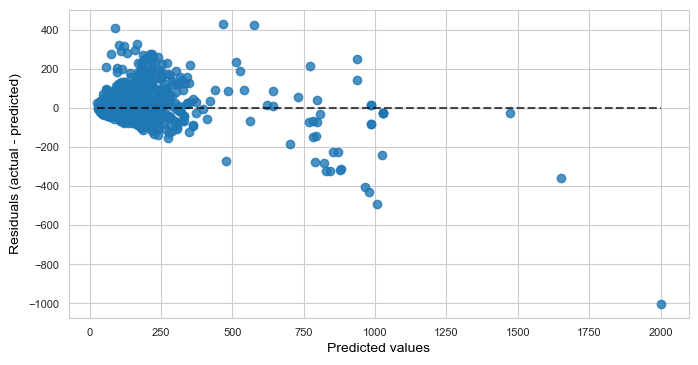

In [70]:
disp = PredictionErrorDisplay.from_estimator(model, X_test, y_test)

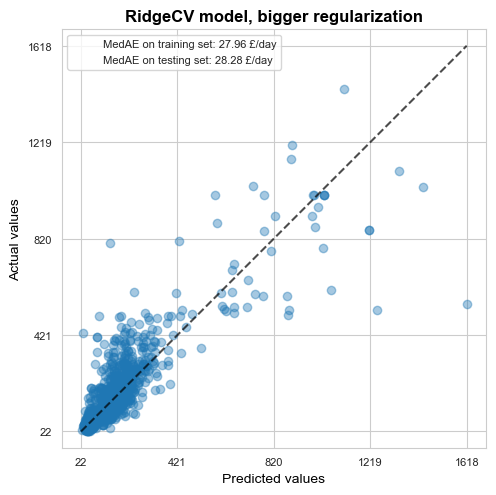

In [71]:
mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} £/day",
    "MedAE on testing set": f"{mae_test:.2f} £/day",
}

_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_true=y_test, y_pred=y_test_preds, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.4}
)
ax.set_title("RidgeCV model, bigger regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

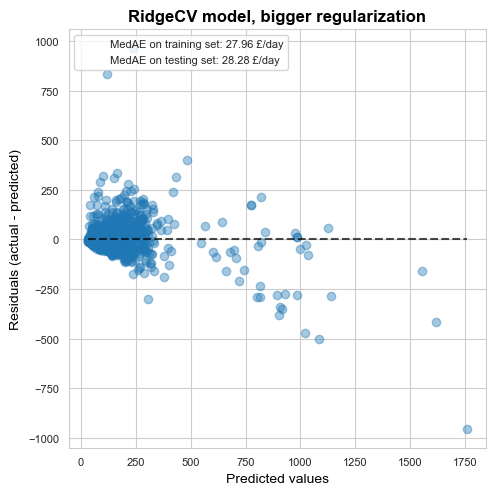

In [72]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_true=y_test, y_pred=y_test_preds, ax=ax, scatter_kwargs={"alpha": 0.4}
)
ax.set_title("RidgeCV model, bigger regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

In [73]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
#     df_results = df_results.reset_index()
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.0
Residuals are not normally distributed


/opt/anaconda3/envs/ds_udacity_projects/lib/python3.10/site-packages/statsmodels/stats/_adnorm.py:67: RuntimeWarning: divide by zero encountered in log1p
  s = np.sum((2 * i[sl1] - 1.0) / nobs * (np.log(z) + np.log1p(-z[sl2])),


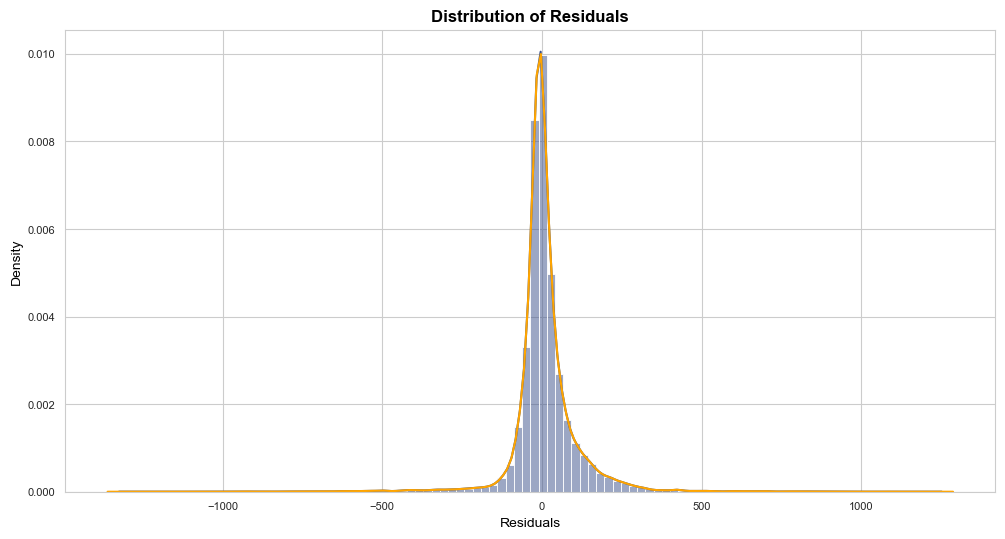


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables


In [74]:
def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    from statsmodels.stats.diagnostic import normal_ad
    print('Assumption 2: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, label)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.subplots(figsize=(12,6))
    plt.title('Distribution of Residuals')
    
    ax = sns.histplot(df_results['Residuals'], bins=100, stat='density', kde=True, color=BASE_COLOR)
    sns.kdeplot(df_results['Residuals'], color='orange', ax=ax)
    
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')
        
normal_errors_assumption(model, X_train, y_train)        

Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


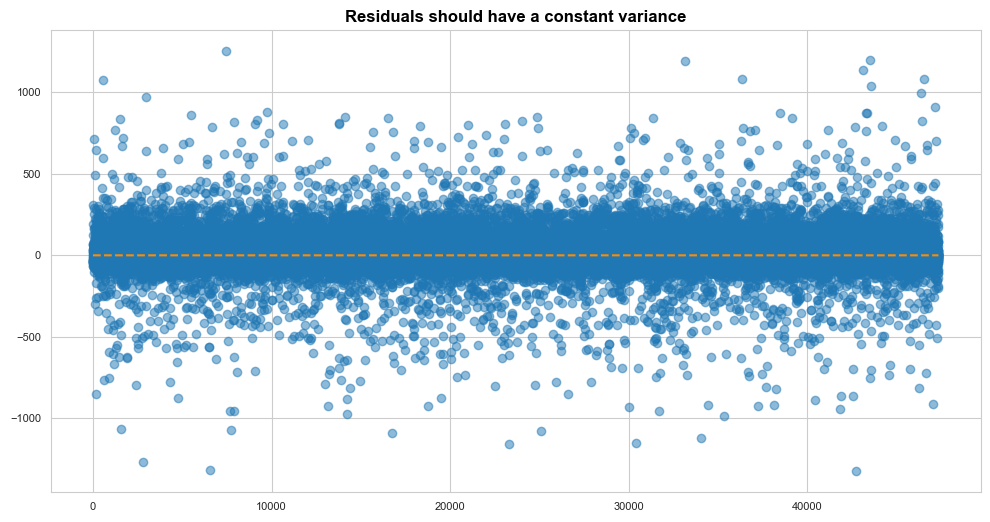

In [75]:
def homoscedasticity_assumption(model, features, label):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print('Assumption 5: Homoscedasticity of Error Terms', '\n')
    
    print('Residuals should have relative constant variance')
        
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    df_results.reset_index(inplace=True)

    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot()  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
#     ax.spines['right'].set_visible(False)  # Removing the right spine
#     ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals should have a constant variance')
    plt.show()  
    
homoscedasticity_assumption(model, X_train, y_train) 

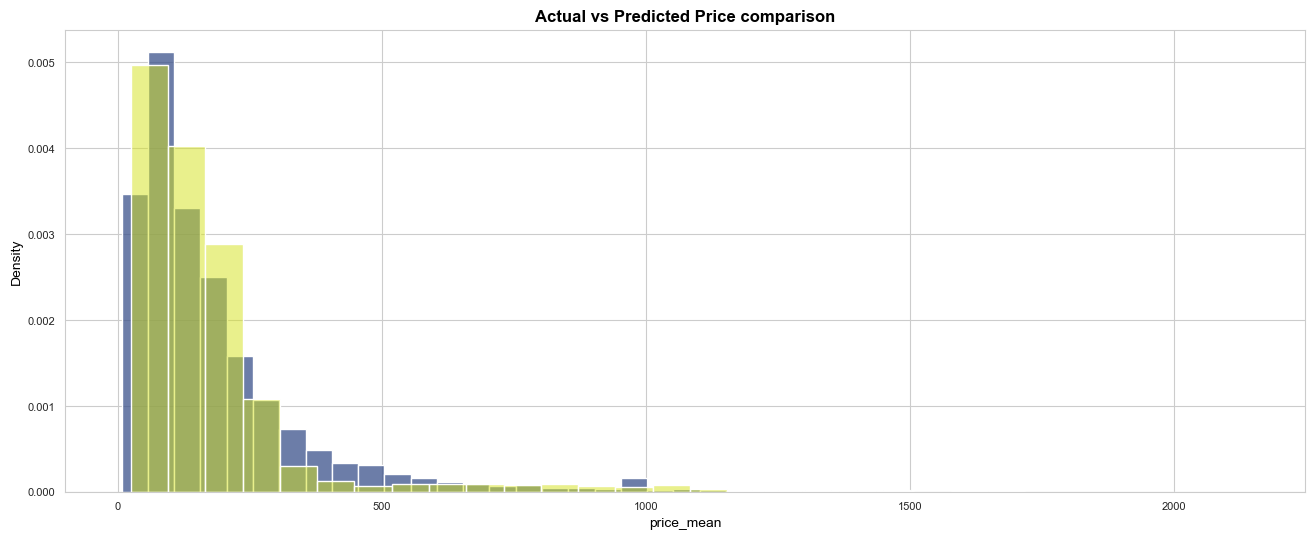

In [76]:
# Actual vs predicted price comparision
ax, fig = plt.subplots(figsize=(16,6), sharex=True)

xbins = np.arange(0, 1600, 100)

ax = sns.histplot(y_test, bins=30, stat='density', kde=False, color=BASE_COLOR, label='actual')
sns.histplot(y_test_preds, bins=30, stat='density', kde=False, color=BASE_COMPLEMENTRY, alpha=0.5, label='predicted', ax=ax)

# plt.xticks(xbins, xbins)
plt.title('Actual vs Predicted Price comparison')

plt.show()

# reset default plot formatting back as PairGrid change the defaults somehow
BASE_COLOR, BASE_HIGHLIGHT_INTENSE, BASE_HIGHLIGHT, BASE_COMPLEMENTRY, BASE_GREY, BASE_COLOR_ARR, BASE_COLOR_DEP, SYMBOLS = vs.set_plot_defaults()

In [77]:
def coef_weights(coefficients):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = feature_names = model[:-1].get_feature_names_out()
    coefs_df['coefs'] = model[-1].regressor_.coef_
    coefs_df['abs_coefs'] = abs(model[-1].regressor_.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    
    coefs_df = coefs_df.set_index('est_int')    
    
    return coefs_df

#Use the function
coef_df = coef_weights(model)


#A quick look at the top results
coef_df

coefs  abs_coefs
est_int                                                              
property_type_shared_room_in_hostel              -0.584351   0.584351
property_type_private_room                       -0.186754   0.186754
property_type_entire_serviced_apartment           0.182219   0.182219
neighbourhood_cleansed_city_of_london             0.181566   0.181566
property_type_entire_cottage                      0.170075   0.170075
neighbourhood_cleansed_westminster                0.167168   0.167168
property_type_private_room_in_home               -0.161351   0.161351
neighbourhood_cleansed_kensington_and_chelsea     0.159971   0.159971
property_type_room_in_aparthotel                  0.155664   0.155664
property_type_private_room_in_casa_particular    -0.152079   0.152079
property_type_shared_room_in_rental_unit         -0.144610   0.144610
property_type_shared_room_in_home                -0.143904   0.143904
property_type_room_in_boutique_hotel              0.142914   0.142914
property_type_entire_condo                        0.142260   0.142260
property_type_private_room_in_rental_unit        -0.141683   0.141683
property_type_entire_villa                        0.139681   0.139681
property_type_entire_loft                         0.136069   0.136069
property_type_shared_room_in_condo               -0.135321   0.135321
property_type_entire_townhouse                    0.135079   0.135079
neighbourhood_cleansed_bexley                    -0.133469   0.133469
property_type_entire_bungalow                     0.127152   0.127152
property_type_entire_home                         0.123892   0.123892
property_type_room_in_bed_and_breakfast           0.122875   0.122875
property_type_entire_vacation_home                0.122176   0.122176
property_type_room_in_serviced_apartment          0.122073   0.122073
property_type_room_in_hotel                       0.119651   0.119651
property_type_entire_place                        0.117218   0.117218
neighbourhood_cleansed_camden                     0.115197   0.115197
property_type_private_room_in_townhouse          -0.111206   0.111206
property_type_entire_rental_unit                  0.110292   0.110292
neighbourhood_cleansed_havering                  -0.108147   0.108147
neighbourhood_cleansed_sutton                    -0.105390   0.105390
property_type_private_room_in_hostel             -0.102783   0.102783
neighbourhood_cleansed_barking_and_dagenham      -0.101010   0.101010
price_group                                       0.097093   0.097093
neighbourhood_cleansed_croydon                   -0.093361   0.093361
neighbourhood_cleansed_hammersmith_and_fulham     0.090381   0.090381
property_type_boat                                0.087394   0.087394
property_type_private_room_in_bungalow           -0.083085   0.083085
neighbourhood_cleansed_islington                  0.082247   0.082247
property_type_private_room_in_condo              -0.080247   0.080247
accommodates                                      0.078914   0.078914
private_bathroom_True                             0.076854   0.076854
availability_90                                   0.074516   0.074516
neighbourhood_cleansed_harrow                    -0.072476   0.072476
neighbourhood_cleansed_bromley                   -0.070391   0.070391
neighbourhood_cleansed_enfield                   -0.065607   0.065607
neighbourhood_cleansed_hillingdon                -0.065318   0.065318
neighbourhood_cleansed_wandsworth                 0.064498   0.064498
property_type_private_room_in_guest_suite        -0.063551   0.063551
property_type_infrequent_sklearn                 -0.062458   0.062458
neighbourhood_cleansed_southwark                  0.062105   0.062105
property_type_private_room_in_bed_and_breakfast  -0.058233   0.058233
property_type_private_room_in_vacation_home      -0.056344   0.056344
neighbourhood_cleansed_tower_hamlets              0.055517   0.055517
neighbourhood_cleansed_richmond_upon_thames       0.054731   0.

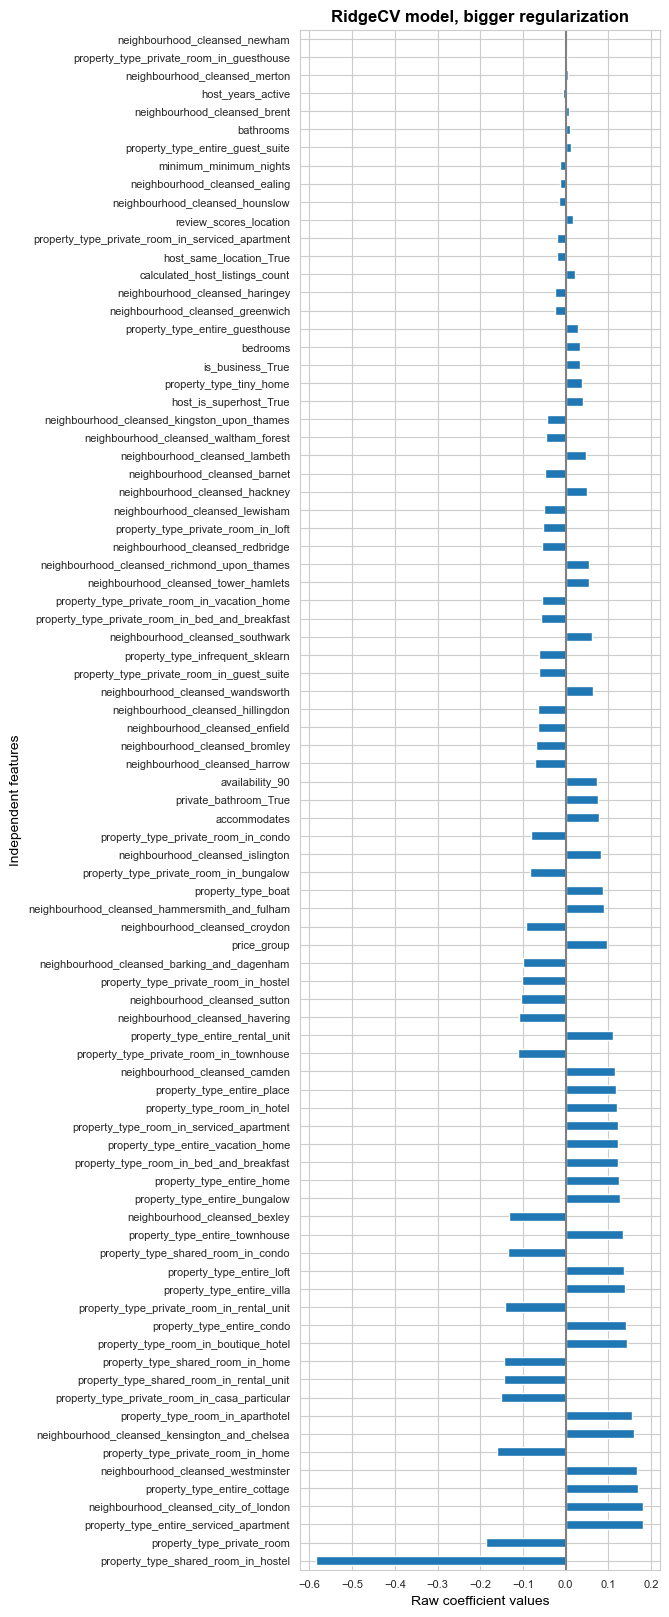

In [78]:
# ax, fig = plt.subplots(figsize=(6,20))

coef_df['coefs'].plot.barh(figsize=(6,20))
plt.title("RidgeCV model, bigger regularization")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.ylabel('Independent features')
plt.subplots_adjust(left=0.3)
plt.show()

Now that the coefficients have been scaled, we can safely compare them.

<div class="alert alert-danger"><h4>Warning</h4><p>Why does the plot above suggest that an increase in age leads to a
  decrease in wage? Why the `initial pairplot
  <marginal_dependencies>` is telling the opposite?</p></div>

The plot above tells us about dependencies between a specific feature and
the target when all other features remain constant, i.e., **conditional
dependencies**. An increase of the AGE will induce a decrease
of the WAGE when all other features remain constant. On the contrary, an
increase of the EXPERIENCE will induce an increase of the WAGE when all
other features remain constant.
Also, AGE, EXPERIENCE and EDUCATION are the three variables that most
influence the model.

## Checking the variability of the coefficients

We can check the coefficient variability through cross-validation:
it is a form of data perturbation (related to
[resampling](https://en.wikipedia.org/wiki/Resampling_(statistics))).

If coefficients vary significantly when changing the input dataset
their robustness is not guaranteed, and they should probably be interpreted
with caution.

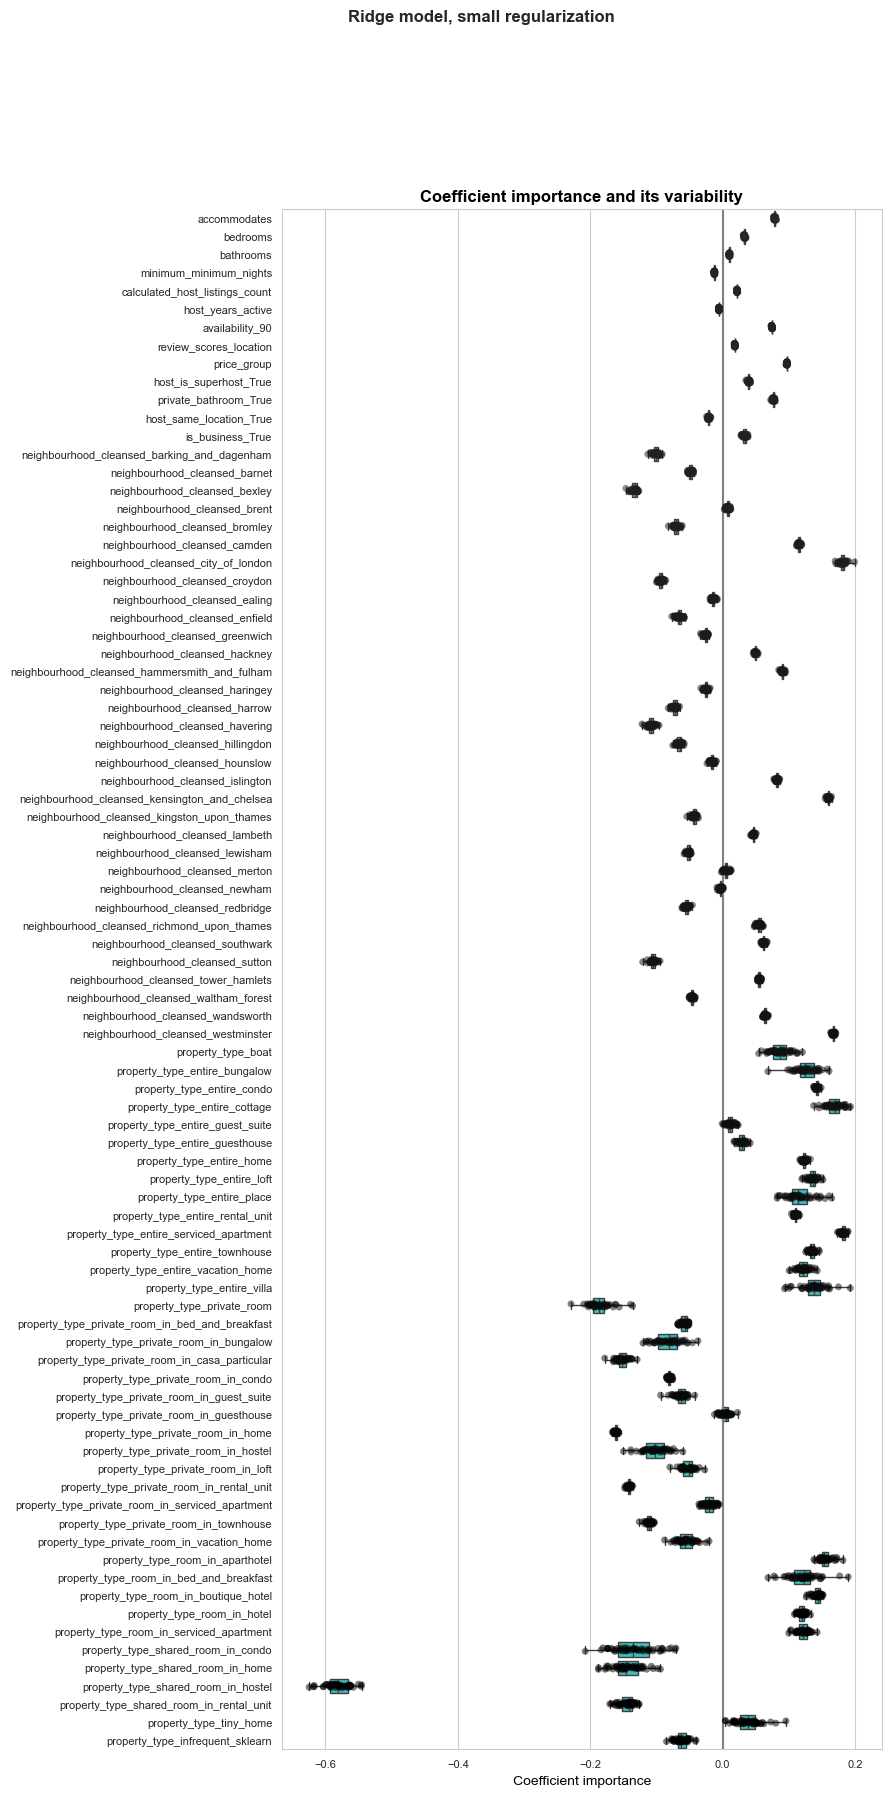

In [79]:
feature_names = model[:-1].get_feature_names_out()

cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=0)

cv_model = cross_validate(
    model,
    X_train,
    y_train,
    cv=cv,
    return_estimator=True,
    n_jobs=10,
)

coefs = pd.DataFrame(
    [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names
)

plt.figure(figsize=(10, 20))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.suptitle("Ridge model, small regularization")
plt.subplots_adjust(left=0.3)

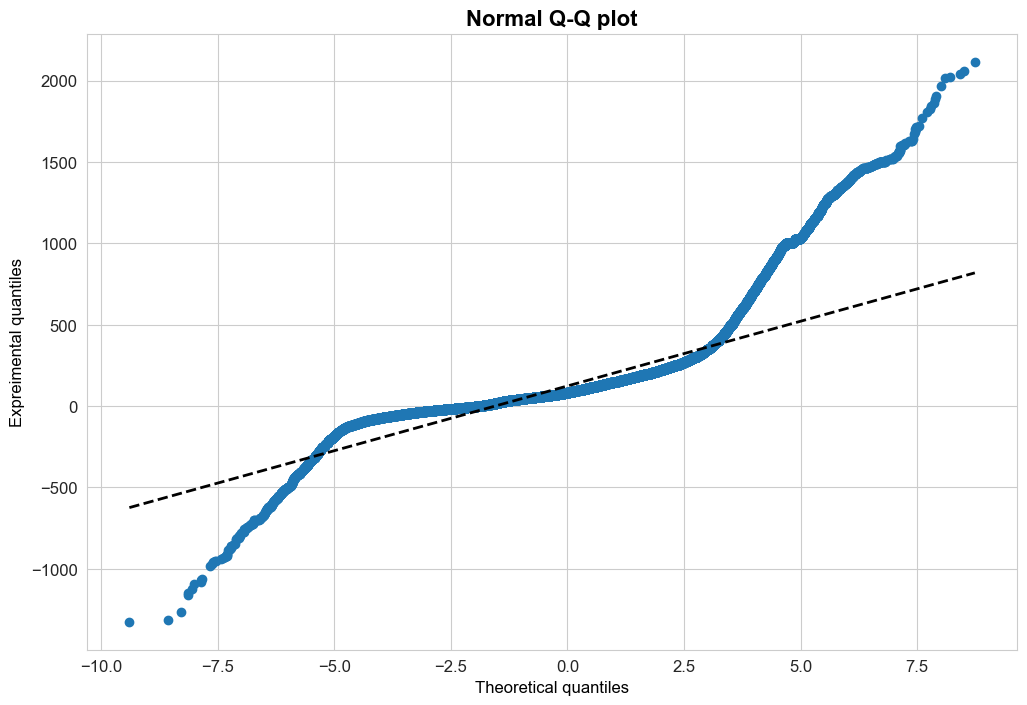

In [80]:
#Assess Q-Q plot
import numpy.random as random

# data=residuals.values.flatten()
data = calculate_residuals(model, X_train, y_train).values.flatten()
data.sort()

norm=random.normal(0,2,len(data))
norm.sort()
plt.figure(figsize=(12,8),facecolor='1.0')
plt.plot(norm,data,"o")

#generate a trend line as in http://widu.tumblr.com/post/43624347354/matplotlib-trendline
z = np.polyfit(norm,data, 1)
p = np.poly1d(z)
plt.plot(norm,p(norm),"k--", linewidth=2)
plt.title("Normal Q-Q plot", size=16)
plt.xlabel("Theoretical quantiles", size=12)
plt.ylabel("Expreimental quantiles", size=12)
plt.tick_params(labelsize=12)
plt.show()

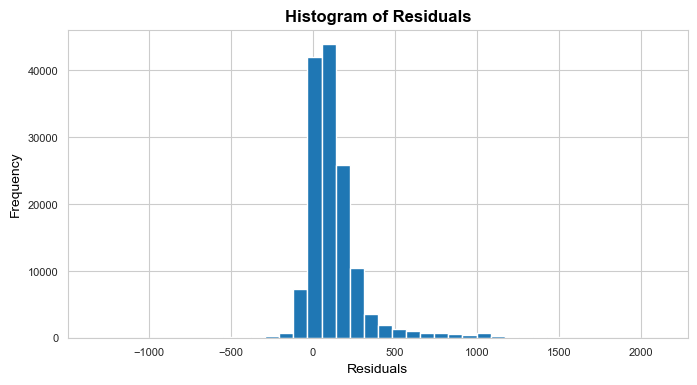

In [81]:
#HISTOGRAM OF RESIDUALS
x = calculate_residuals(model, X_train, y_train).values.flatten()

plt.title('Histogram of Residuals')
plt.hist(x, bins=40)
plt.ylabel('Frequency')
plt.xlabel('Residuals')
plt.show()

# statsmodels model statistics

In [82]:
X_train.head()

accommodates  bedrooms  bathrooms  minimum_minimum_nights  \
listing_id                                                                      
876535713158475266     -0.060223 -0.513893  -0.560503                0.069993   
834086246659249932     -0.610600 -0.513893  -0.560503               -0.369109   
38289518               -0.610600 -0.513893  -0.560503               -0.369109   
812032850489099069      1.040532  0.629373   1.195331                0.289545   
20162405               -0.610600 -0.513893  -0.560503               -0.259334   

                    calculated_host_listings_count  host_years_active  \
listing_id                                                              
876535713158475266                       -0.182082           0.539372   
834086246659249932                        0.187633          -1.312049   
38289518                                 -0.279375          -0.694909   
812032850489099069                        3.106433          -0.694909   
20162405                                 -0.298834          -0.077769   

                    availability_90  review_scores_location  price_group  \
listing_id                                                                 
876535713158475266         0.733017                0.224838    -0.251457   
834086246659249932        -1.042277                0.224838    -0.251457   
38289518                  -1.042277                0.224838    -0.251457   
812032850489099069         0.637912                0.224838    -0.251457   
20162405                  -1.042277                0.224838    -0.251457   

                    host_is_superhost_True  private_bathroom_True  \
listing_id                                                          
876535713158475266                     0.0                    1.0   
834086246659249932                     0.0                    1.0   
38289518                               0.0                    1.0   
812032850489099069                     0.0                    1.0   
20162405                               0.0                    1.0   

                    host_same_location_True  is_business_True  \
listing_id                                                      
876535713158475266                      0.0               0.0   
834086246659249932                      0.0               0.0   
38289518                                0.0               0.0   
812032850489099069                      0.0               0.0   
20162405                                0.0               0.0   

                    neighbourhood_cleansed_barking_and_dagenham  \
listing_id                                                        
876535713158475266                                          0.0   
834086246659249932                                          0.0   
38289518                                                    0.0   
812032850489099069                                          0.0   
20162405                                                    0.0   

                    neighbourhood_cleansed_barnet  \
listing_id                                          
876535713158475266                            0.0   
834086246659249932                            0.0   
38289518                                      0.0   
812032850489099069                            0.0   
20162405                                      0.0   

                    neighbourhood_cleansed_bexley  \
listing_id                                          
876535713158475266                            0.0   
834086246659249932                            0.0   
38289518                                      0.0   
812032850489099069                            0.0   
20162405                                      0.0   

                    neighbourhood_cleansed_brent  \
listing_id                                         
876535713158475266                           0.0   
834086246659249932                           0.0   
38289518                                     

In [83]:
X_ols = X_train.copy(deep=True)
X_ols['intercept'] = 1
lm = sm.OLS(y_train, X_ols)
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             price_mean   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     2265.
Date:                Tue, 21 Nov 2023   Prob (F-statistic):               0.00
Time:                        15:53:02   Log-Likelihood:            -2.7780e+05
No. Observations:               47352   AIC:                         5.558e+05
Df Residuals:                   47268   BIC:                         5.565e+05
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
accommodates                                        25.6448      0.699     36.694      0.000      24.275      27.015
bedrooms                                            19.1374      0.692     27.668      0.000      17.782      20.493
bathrooms                                           11.3437      0.500     22.700      0.000      10.364      12.323
minimum_minimum_nights                              -4.3438      0.398    -10.920      0.000      -5.123      -3.564
calculated_host_listings_count                      19.1582      0.445     43.023      0.000      18.285      20.031
host_years_active                                   -2.5957      0.423     -6.129      0.000      -3.426      -1.766
availability_90                                     23.2209      0.424     54.738      0.000      22.389      24.052
review_scores_location                               5.9022      0.398     14.813      0.000       5.121       6.683
price_group                                        112.4288      0.451    249.309      0.000     111.545     113.313
host_is_superhost_True                              14.4272      1.395     10.343      0.000      11.693      17.161
private_bathroom_True                               14.7598      1.330     11.097      0.000      12.153      17.367
host_same_location_True                              0.8680      1.204      0.721      0.471      -1.492       3.228
is_business_True                                    10.3862      2.104      4.937      0.000       6.263      14.510
neighbourhood_cleansed_barking_and_dagenham        -27.7651      4.525     -6.136      0.000     -36.634     -18.896
neighbourhood_cleansed_barnet                      -16.4573      2.412     -6.823      0.000     -21.185     -11.730
neighbourhood_cleansed_bexley                      -34.8140      4.765     -7.306      0.000     -44.154     -25.474
neighbourhood_cleansed_brent                         3.6238      2.198      1.649      0.099      -0.684       7.931
neighbourhood_cleansed_bromley                     -20.6777      4.095     -5.050      0.000     -28.704     -12.652
neighbourhood_cleansed_camden                       38.1566      1.604     23.793      0.000      35.013      41.300
neighbourhood_cleansed_city_of_london               64.0448      5.059     12.660      0.000      54.130      73.960
neighbourhood_cleansed_croydon                     -25.2013      2.948     -8.549      0.000     -30.979     -19.423
neighbourhood_cleansed_ealing                       -1.2302      2.417     -0.509      0.611      -5.967       3.507
neighbourhood_cleansed_enfield                     -17.7332      3.879     -4.571      0.000     -25.336     -10.130
neighbourhood_cleansed_greenwich         

# references
- [Common pitfalls in the interpretation of coefficients of linear models](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html)
- [Mixed-type imputation for IterativeImputer](https://github.com/scikit-learn/scikit-learn/issues/17087)
- [kaggle feature engineering lesson](https://www.kaggle.com/learn/feature-engineering)
- [boston house prices](https://www.kaggle.com/code/hikmatullahmohammadi/house-price-prediction-eda-step-by-step)
- [linear regression assumptions](https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/)